In [1]:
import tensorflow as tf
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from skimage import util
from math import exp, log, pow
from tensorflow.python.keras.engine.base_layer import Layer
from matplotlib import rc
rc('mathtext', default='regular')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
class CIFARLoader():
    def __init__(self):
        (self.train_data, self.train_label), (self.test_data, self.test_label) = tf.keras.datasets.cifar10.load_data()
       
        self.train_data = self.train_data.astype(np.float32)/ 255.0     # [50000, 32, 32, 3]
        self.test_data = self.test_data.astype(np.float32) / 255.0      # [10000, 32, 32, 3]
        self.train_label = self.train_label.astype(np.int32)    # [50000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
    def get_local_noise(self, noise_num=400, batch_size=2000):
        """
        Generate noise_num # of gassaion noise knowing location 
        
        """

        process_image = np.copy(self.test_data[:batch_size])
        W_x = intitial_W_x(process_image)
        uncer_mass = np.zeros(W_x[:,0,0,:,0].shape) + 0.01
        base_rate = np.zeros(W_x[:,0,0,:,0].shape) + 0.5
        image_size = process_image.shape[1]
        index_noise = np.random.randint(0, image_size*image_size, noise_num)
        
        for i in index_noise:
            noise_value = np.random.randn(batch_size,3) * 0.4
            feature_value = process_image[:,int(i/image_size),int(i%image_size),:]
            process_image[:,int(i/image_size),int(i%image_size),:] = feature_value + noise_value
            belief_mass = W_x[:,int(i/image_size),int(i%image_size),:,0] * (1-noise_value)
            disbelief_mass = 1 - belief_mass - uncer_mass
            W_x[:,int(i/image_size),int(i%image_size),:] = np.moveaxis(np.array([belief_mass,disbelief_mass,uncer_mass,base_rate]), 0, -1)
            
        return tf.clip_by_value(process_image, 0, 1), self.test_label[:batch_size], W_x, index_noise
    
    def get_noise(self, noise_mode):
        process_image = np.copy(self.test_data[:2000])
        noise_gs_img = util.random_noise(process_image,mode=noise_mode)
        return noise_gs_img, self.test_label[:2000]

    def get_test(self, size):

        return self.test_data[:size], self.test_label[:size]
    
data_loader = CIFARLoader()

In [4]:
def intitial_W_x(X):
    """
    X - 50,32,32,3
    return W_x - 50,32,32,3,4
    
    """
    W_dis = np.zeros(X.shape).astype(np.float32)
    W_base = W_dis + 0.5
    W_x = np.array([X, W_dis, 1 - X, W_base]).astype(np.float32)
    W_x = np.moveaxis(W_x, 0, -1)
    
    return W_x

In [5]:
def intitial_W_x_test(X):
    """
    X - 50,32,32,3
    return W_x - 50,32,32,3,4
    
    """
    W_dis = np.zeros(X.shape).astype(np.float32)
    W_belief = W_dis + 0.99
    W_base = W_dis + 0.5
    W_x = np.array([W_belief, W_dis, 1 - W_belief, W_base]).astype(np.float32)
    W_x = np.moveaxis(W_x, 0, -1)
    
    return W_x

In [6]:
def intitial_W_x_location(X, index):
    """
    X - 5000,28,28,1
    return W_x - 400,
    
    """
    W_x = intitial_W_x(X)
    uncer_mass = np.zeros(W_x[:,0,0,:,0].shape) + 0.01
    base_rate = np.zeros(W_x[:,0,0,:,0].shape) + 0.5
    image_size = X.shape[1]
    for i in index:
        belief_mass = W_x[:,int(i/image_size),int(i%image_size),:,0]
        disbelief_mass = 1 - belief_mass - uncer_mass
        W_x[:,int(i/image_size),int(i%image_size),:] = np.moveaxis(np.array([belief_mass,disbelief_mass,uncer_mass,base_rate]), 0, -1)

    return W_x

In [7]:
def padding(opinion, kernel_size):
    """
    opinion - (batch_size 500, image_size 32， image_size 32，channel 3, 4) 
    W_w - (kernel_size, kernel_size, 3, filter_num, 4)
    p - int(( n_W_prev - f + 2 * pad )/ stride) + 1
    
    """
    image_size = opinion.shape[1]
    p = int((kernel_size - 1)/2)
    padding_size = int(image_size + 2 * p)
    opinion_pad = np.zeros((int(opinion.shape[0]),padding_size,padding_size,int(opinion.shape[-2]),int(opinion.shape[-1])))
    opinion_pad[:,:,:,:] = np.array([0.0, 0.99, 0.01, 0.5])
    opinion_pad[:,p:p+image_size,p:p+image_size,:,:] = opinion
    return opinion_pad

In [8]:
def multi(W_x, W_y): # 
#     print(np.isnan(np.min(W_x[0]*W_y[0])))    
    W_b = W_x[0]*W_y[0]+((1-W_x[3])*W_y[3]*W_x[0]*W_y[2]+W_x[3]*(1-W_y[3])*W_y[0]*W_x[2])/(1-W_x[3]*W_y[3])
#     print(np.isnan(np.min(W_b)))
    W_d = W_x[1]+W_y[1]-W_x[1]*W_y[1]
    W_u = W_x[2]*W_y[2]+((1-W_y[3])*W_x[0]*W_y[2]+(1-W_x[3])*W_y[0]*W_x[2])/(1-W_x[3]*W_y[3])
    W_a = W_x[3]*W_y[3]
    return W_b,W_d,W_u,W_a

In [9]:
def conv_single_step_trust(W_x, W_w, W_b): 
    """
    W_x - (50,5,5,3,4)
    W_w - (5,5,3,32,4)
    W_b - (32,4)
    W_wx - (4, 32, 3, 5, 5)
    fusion_result - (32,)
    
    """    
    W_x = W_x.astype(np.float64)   
    W_w = W_w.numpy().astype(np.float64) 
    W_b = W_b.numpy().astype(np.float64) 
    
    filter_number = W_b.shape[0]
    batch_size = W_x.shape[0]
    fusion_result = []
    W_x_expand = np.tile(np.expand_dims(W_x, axis=(4)), [1,1,1,1,filter_number,1])
    W_w_expand = np.tile(np.expand_dims(W_w, axis=(0)), [batch_size,1,1,1,1,1])
    W_b_expand = np.tile(np.expand_dims(W_b, axis=(0)), [batch_size,1,1])
#     print(W_x_expand,W_w_expand)
#     print('W_x_expand',np.isnan(np.min(W_x_expand)))
#     print('W_w_expand',np.isnan(np.min(W_w_expand)))
    W_wx = multi(np.transpose(W_x_expand),np.transpose(W_w_expand)) # (4, 32, 3, 5, 5, 50)
#     print(np.asarray(W_wx)[:])
#     print(np.isnan(np.min(W_wx)))
    fusion_result = avg_fusion(np.asarray(W_wx), np.transpose(W_b_expand))
#     print(np.isnan(np.min(fusion_result[0])))
    return np.transpose(fusion_result[0]),np.transpose(fusion_result[1])



def avg_fusion(W_wx, W_b):
    """
    W_wx - (4, 32, 3, 5, 5, 50)
    W_b -  (4, 32, 50)
    fusion_result - (32, 32, 32)
    
    return opinion - 4,32,50
           trust - 32,50
    """
    
    W_wx = np.reshape(W_wx, (W_wx.shape[0],W_wx.shape[1], 
                             W_wx.shape[2]*W_wx.shape[3]*W_wx.shape[4], W_wx.shape[5])).astype(np.float64) # (4, 32, 75, 50)
    W_b = W_b.astype(np.float64)
    
    n_filter = W_b.shape[1]
    batch_size = W_wx.shape[-1]
    num_para = W_wx.shape[2]
#     print(num_para)
    b_wx, u_wx, a_wx = W_wx[0], W_wx[2], W_wx[3]
    b_b, u_b, a_b = W_b[0], W_b[2], W_b[3]
        
    
    u_combine = np.concatenate((u_wx, np.reshape(u_b,(u_b.shape[0], 1, batch_size))), axis=1) # (32, 76, 50)
    b_combine = np.concatenate((b_wx, np.reshape(b_b,(b_b.shape[0], 1, batch_size))), axis=1) # (32, 76, 50)
    u_combine_recip = (np.zeros(u_combine.shape)+1)/u_combine
    
    numerator = np.sum(b_combine * u_combine_recip, axis = 1) # (32, 50)
    denominator = np.sum(u_combine_recip, axis = (1))
    
    b_fusion = numerator / denominator
    u_fusion = (num_para+1) / denominator
    a_fusion = (np.sum(a_wx, axis=(1)) + a_b) / (num_para+1)
    
    return np.array([b_fusion, 1-b_fusion-u_fusion, u_fusion, a_fusion]).astype(np.float32), (b_fusion + u_fusion * a_fusion).astype(np.float32)

In [10]:
def conv_forward(A_prev, W_w, W_b):
    """
        A_prev - (batch_size 500, image_size 32， image_size 32，channel 3, 4) 
        W_w - (kernel_size, kernel_size, 3, filter_num, 4)
        W_b - (filter_num, 4)
        return Z - (28, 28, filter_num, 4)

    """
    (batch_size, n_H_prev, n_W_prev, _, _) = A_prev.shape 

    ( f , f , _, n_C, _) = W_w.shape

    stride = 1
    pad = 1
    

    A_prev_pad = padding(A_prev,f)
    
    n_H = int(( n_H_prev - f + 2 * pad )/ stride) + 1
    n_W = int(( n_W_prev - f + 2 * pad )/ stride) + 1
 
    Z = np.zeros((batch_size, n_H, n_W, n_C, 4)) 
    Z_trust = np.zeros((batch_size, n_H, n_W, n_C))

    for h in range(n_H):                       
        for w in range(n_W):                              
            vert_start = h * stride         
            vert_end = vert_start + f       
            horiz_start = w * stride       
            horiz_end = horiz_start + f     

            a_slice_prev = A_prev_pad[:,vert_start:vert_end,horiz_start:horiz_end,:,:]   # 500, 3, 3, 3, 4
#             print(a_slice_prev)
#             print('a_slice_prev :', np.isnan(np.min(a_slice_prev)))
            opinion, trust = conv_single_step_trust(a_slice_prev,W_w,W_b)   
#             print(opinion.shape)
            Z[:,h,w,:,:] = opinion
            Z_trust[:,h,w,:] = trust
#     print(Z.shape,Z_trust.shape)
    return Z, Z_trust

In [11]:
class MyLayer(tf.keras.layers.Layer):
    """
    max-trust fuction layer
    
    """
    def __init__(self):
        super(MyLayer, self).__init__()


    def call(self, x, opinion, trust):
        """
        x - (50, 28, 28, 32)
        opinion - (50, 28, 28, 32, 4)
        trust - (50, 28, 28, 32)
        
        x, pooling_opinion1 = self.maxtrust(x, opinion1, trust1)

        opinion_out - (50, 14, 14, 32, 4)
        return - (50, 14, 14, 32, 4)

        """
    #         print(inputs.shape,inputB.shape)
        trust_mul = np.zeros(x.shape)
        image_size = x.shape[1]
        opinion_out = np.zeros((opinion.shape[0],int(opinion.shape[1]/2), int(opinion.shape[2]/2),opinion.shape[3], 4)).astype(np.float32)
#         print(opinion_out.shape)
        for i in range(trust.shape[0]):
            for k in range(trust.shape[-1]):
                input_max = trust[i,:,:,k].reshape((1,trust.shape[1],trust.shape[2],1))
                _, argmax = tf.nn.max_pool_with_argmax(input = input_max, ksize = [1, 2, 2, 1],
                                                    strides = [1, 2, 2, 1], padding = 'VALID')
                argmax_1d = argmax.numpy().flatten()
#                 print(len(argmax_1d))
            
                for j in range(len(argmax_1d)):
                    trust_mul[i,int(argmax_1d[j]/image_size),int(argmax_1d[j]%image_size),k] = 1
                    opinion_out[i,int(j/int(image_size/2)), int(j%int(image_size/2)),k,:] = opinion[i,int(argmax_1d[j]/image_size),int(argmax_1d[j]%image_size),k,:] 

        x = x * trust_mul

        return x, opinion_out

In [12]:
class MyLayer_CONV(tf.keras.layers.Layer):
    """
    max-trust fuction layer
    
    """
    def __init__(self):
        super(MyLayer_CONV, self).__init__()


    def call(self, input1, input2, input3):
        
        Z, Z_trust = conv_forward(input1, input2, input3)
           
        return Z.astype(np.float32), Z_trust.astype(np.float32)

In [13]:
class MyLayer_Pool(tf.keras.layers.Layer):
    """
    original max-pooling with trust
     
    """
    def __init__(self):
        super(MyLayer_Pool, self).__init__()


    def call(self, x, opinion):
        """
        x-(50,16,16,8)
        
        """
        image_size = x.shape[1]
        trust_mul = np.zeros(x.shape)
    
        opinion_out = np.zeros((opinion.shape[0],int(opinion.shape[1]/2), 
                                int(opinion.shape[2]/2),opinion.shape[3], 4)).astype(np.float32)

        for i in range(x.shape[0]):
            for k in range(x.shape[-1]):
                input_max = x[i,:,:,k].numpy().reshape((1,x.shape[1],x.shape[2],1))
                _, argmax = tf.nn.max_pool_with_argmax(input = input_max, ksize = [1, 2, 2, 1],
                                                    strides = [1, 2, 2, 1], padding = 'VALID')

                argmax_1d = argmax.numpy().flatten()

                for j in range(len(argmax_1d)):
                    trust_mul[i,int(argmax_1d[j]/image_size),int(argmax_1d[j]%image_size),k] = 1
                    opinion_out[i,int(j/int(image_size/2)), int(j%int(image_size/2)),k,:] = opinion[i,int(argmax_1d[j]/image_size),
                                                                                                    int(argmax_1d[j]%image_size),k,:] 
        x = x * trust_mul
        
        return x, opinion_out

In [14]:
def get_update_matrix(grads_w, grads_b, rs):
    """
    grads_list_w1 = grads_list_w + tf.where(abs(tf.squeeze(grads[0]))<0.01, 1, 0)  #  shape=(5, 5, 3, 32)
    grads_list_b1 = grads_list_b + tf.where(abs(tf.squeeze(grads[1]))<0.01, 1, 0)  #  shape=(32,)
    grads_list_w2 = grads_list_w + tf.where(abs(tf.squeeze(grads[0]))<0.01, 1, 0)  #  shape=(5, 5, 32, 64)
    grads_list_b2 = grads_list_b + tf.where(abs(tf.squeeze(grads[1]))<0.01, 1, 0)  #  shape=(64,)
    grads_list_w3 = grads_list_w + tf.where(abs(tf.squeeze(grads[0]))<0.01, 1, 0)  #  shape=(5, 5, 64, 64)
    grads_list_b3 = grads_list_b + tf.where(abs(tf.squeeze(grads[1]))<0.01, 1, 0)  #  shape=(64,)
    
    """
    
    W_w = np.array([grads_w/(rs+2),(rs-grads_w)/(rs+2),np.full(grads_w.shape, 2/(rs+2)),
                    np.full(grads_w.shape, 0.5)]).astype(np.float32)
    W_b = np.array([grads_b/(rs+2), (rs-grads_b)/(rs+2), np.full(grads_b.shape, 2/(rs+2)), 
                    np.full(grads_b.shape, 0.5)]).astype(np.float32)
    W_w = np.moveaxis(W_w, 0, -1)
    
    return W_w, W_b.swapaxes(0,1)

In [15]:
def evidence_collect(y, y_pred):
    r = 0
    s = 0
    r_list = [0]*10
    s_list = [0]*10
    
    for j in range(len(y_pred)):
        for i in range(len(y_pred[0])):
            if i == y[j]:
                if y_pred[j][i] > 0.5:
                    r_list[i]+=1
                    r+=1
                else:
                    s+=1
                    s_list[i]+=1
            else:
                if y_pred[j][i] < 0.1:
                    r_list[i]+=1
                else:
                    s_list[i]+=1
                    
    y_N_op = []
    for i in range(len(r_list)):
        y_N_op.append([r_list[i]/(r_list[i]+s_list[i]+2), 
                       s_list[i]/(r_list[i]+s_list[i]+2), 2/(r_list[i]+s_list[i]+2), 0.5])

    
    return [r/(r+s+2), s/(r+s+2), 2/(r+s+2), 0.5], y_N_op

In [16]:
filter_num1 = 16
filter_num2 = 32
filter_num3 = 32
kernelsize = 3

In [17]:
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.convopinion1 = MyLayer_CONV()
        self.convopinion2 = MyLayer_CONV()
        self.convopinion3 = MyLayer_CONV()
        
#         self.denseopinion1 = MyLayer_Dense()
#         self.denseopinion2 = MyLayer_Dense()

        self.conv1 = tf.keras.layers.Conv2D(
            filters=filter_num1,             
            kernel_size=[kernelsize, kernelsize],
            padding='same',
            activation=tf.nn.relu   
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=filter_num2,           
            kernel_size=[kernelsize, kernelsize],    
            padding='same',
            activation=tf.nn.relu   
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=filter_num3,            
            kernel_size=[kernelsize, kernelsize],     
            padding='same',         
            activation=tf.nn.relu   
        )

        self.maxtrust1 = MyLayer()
        self.maxfeature1 = MyLayer_Pool()
        self.maxfeature2 = MyLayer_Pool()
        
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
       
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)

    def call(self, inputs):
        """
        x - 50,32,32,3
        W_x - 50,32,32,3,4
        
        
        """
        X, W_x, W_w1, W_b1, W_w2, W_b2 = inputs
 
        opinion1, trust1 = self.convopinion1(W_x, W_w1, W_b1)
        x = self.conv1(X)   
#         print(np.isnan(np.min(opinion1)))
#         print('Underflow or not: ',np.isnan(np.min(trust1)))
#         print(opinion1.shape,trust1.shape)
#         x, pooling_opinion1 = self.maxtrust1(x, opinion1, trust1)
        x, pooling_opinion1 = self.maxfeature1(x, opinion1)
        x = self.pool1(x) 
#         print('First 2 layers end:',(time.time()-start))
#         print(np.isnan(np.min(x)))
#         print(np.isnan(np.min(pooling_opinion1)))
        opinion2, trust2 = self.convopinion2(pooling_opinion1, W_w2, W_b2)
        x = self.conv2(x)
        
        x, pooling_opinion2 = self.maxfeature2(x, opinion2)
        x = self.pool2(x)
        print('underflow or not:',np.isnan(np.min(opinion2)))
#         print(np.isnan(np.min(x)))
#         print('Second 2 layers end:',(time.time()-start))
        
        x = self.flatten(x) 
        x = self.dense1(x)    
        output = self.dense2(x)                    
        return output,trust1,trust2,pooling_opinion2
    
model = CNN()

In [18]:
num_epochs = 10
batch_size = 50
# threshold1 = 20
# threshold2 = 15
optimizer = tf.keras.optimizers.Adam()
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [19]:
train_acc = []
train_loss = []
opinion_convlist = []
y_update_wb = []
y_N_opinion = []

In [19]:
# batch training process
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)

W_w1 = np.array([[[[[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num1)] for _ in range(3)]  # (3,3,3,8,4)
                  for _ in range(kernelsize)] for _ in range(kernelsize)]).astype(np.float32)

W_b1 = np.array([[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num1)]).astype(np.float32) # (8,4)

W_w2 = np.array([[[[[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num2)] for _ in range(filter_num1)] 
                  for _ in range(kernelsize)] for _ in range(kernelsize)]).astype(np.float32)

W_b2 = np.array([[0.0, 0.0, 1.0, 0.5] for _ in range(filter_num2)]).astype(np.float32)

grads_list_w1 = np.zeros((kernelsize,kernelsize,3,filter_num1))
grads_list_b1 = np.zeros((filter_num1,))
grads_list_w2 = np.zeros((kernelsize,kernelsize,filter_num1,filter_num2))
grads_list_b2 = np.zeros((filter_num2,))
grads_list_w3 = np.zeros((filter_num2*8*8, 64))
grads_list_b3 = np.zeros((64,))
grads_list_w4 = np.zeros((64, 10))
grads_list_b4 = np.zeros((10,))

start = time.time()

for batch_index in range(num_batches):
    print('# of batch:',batch_index)
    X, y = data_loader.get_batch(batch_size)  
    W_x = intitial_W_x(X)
    with tf.GradientTape() as tape:
        y_pred,trust1,trust2,opinion_conv = model([X, W_x, W_w1, W_b1, W_w2, W_b2])
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)

    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    # sparse_categorical_accuracy.reset_states()
    sparse_categorical_accuracy.update_state(y_true=y, y_pred=y_pred)

    print("train accuracy:",sparse_categorical_accuracy.result().numpy())
#     print('Model update end:',(time.time()-start))
      
# update W_w, W_b
    grads_list_w1 = grads_list_w1 + tf.where(abs(grads[0]) < np.average(abs(grads[0])), 1, 0)  #  shape=(5, 5, 3, 8)
    grads_list_b1 = grads_list_b1 + tf.where(abs(grads[1]) < np.average(abs(grads[1])), 1, 0)  #  shape=(8,)
    grads_list_w2 = grads_list_w2 + tf.where(abs(grads[2]) < np.average(abs(grads[2])), 1, 0)  #  shape=(5, 5, 8, 12)
    grads_list_b2 = grads_list_b2 + tf.where(abs(grads[3]) < np.average(abs(grads[3])), 1, 0)  #  shape=(12,) 
    
#     grads_list_w3 = grads_list_w3 + tf.where(abs(grads[4]) < np.average(abs(grads[4]*1.5)), 1, 0) 
#     grads_list_b3 = grads_list_b3 + tf.where(abs(grads[5]) < np.average(abs(grads[5]*1.5)), 1, 0) 
#     grads_list_w4 = grads_list_w4 + tf.where(abs(grads[6]) < np.average(abs(grads[6]*1.5)), 1, 0) 
#     grads_list_b4 = grads_list_b4 + tf.where(abs(grads[7]) < np.average(abs(grads[7]*1.5)), 1, 0) 
    
    W_w1, W_b1 = get_update_matrix(grads_list_w1, grads_list_b1, batch_index+1)                               
    W_w2, W_b2 = get_update_matrix(grads_list_w2, grads_list_b2, batch_index+1)
#     W_w3, W_b3 = get_update_matrix(grads_list_w3, grads_list_b3, batch_index+1)
#     W_w4, W_b4 = get_update_matrix(grads_list_w4, grads_list_b4, batch_index+1)

    y_N_update, y_N_op = evidence_collect(y, y_pred)  
    y_N_opinion.append(y_N_op)
    y_update_wb.append(y_N_update)
   
    print('One batch end:',(time.time()-start))

# of batch: 0
underflow or not: False
train accuracy: 0.12
One batch end: 17.424015283584595
# of batch: 1
underflow or not: False
train accuracy: 0.1
One batch end: 28.451297283172607
# of batch: 2
underflow or not: False
train accuracy: 0.11333334
One batch end: 39.441107988357544
# of batch: 3
underflow or not: False
train accuracy: 0.095
One batch end: 51.0155816078186
# of batch: 4
underflow or not: False
train accuracy: 0.1
One batch end: 62.12267184257507
# of batch: 5
underflow or not: False
train accuracy: 0.1
One batch end: 73.19206357002258
# of batch: 6
underflow or not: False
train accuracy: 0.117142856
One batch end: 84.22751951217651
# of batch: 7
underflow or not: False
train accuracy: 0.1175
One batch end: 95.2389166355133
# of batch: 8
underflow or not: False
train accuracy: 0.11111111
One batch end: 106.3612711429596
# of batch: 9
underflow or not: False
train accuracy: 0.108
One batch end: 117.80171060562134
# of batch: 10
underflow or not: False
train accuracy: 0.1

underflow or not: False
train accuracy: 0.22588235
One batch end: 997.4117298126221
# of batch: 85
underflow or not: False
train accuracy: 0.2272093
One batch end: 1009.0446910858154
# of batch: 86
underflow or not: False
train accuracy: 0.22804597
One batch end: 1020.58913397789
# of batch: 87
underflow or not: False
train accuracy: 0.22931819
One batch end: 1032.2435870170593
# of batch: 88
underflow or not: False
train accuracy: 0.22966293
One batch end: 1043.85031914711
# of batch: 89
underflow or not: False
train accuracy: 0.23155555
One batch end: 1055.4234476089478
# of batch: 90
underflow or not: False
train accuracy: 0.23362638
One batch end: 1067.018434047699
# of batch: 91
underflow or not: False
train accuracy: 0.23608695
One batch end: 1078.6401374340057
# of batch: 92
underflow or not: False
train accuracy: 0.23741935
One batch end: 1090.2253444194794
# of batch: 93
underflow or not: False
train accuracy: 0.23829788
One batch end: 1101.9118993282318
# of batch: 94
underfl

underflow or not: False
train accuracy: 0.29628742
One batch end: 1949.691550731659
# of batch: 167
underflow or not: False
train accuracy: 0.29714286
One batch end: 1961.3604605197906
# of batch: 168
underflow or not: False
train accuracy: 0.29786983
One batch end: 1972.998004436493
# of batch: 169
underflow or not: False
train accuracy: 0.2984706
One batch end: 1984.7205777168274
# of batch: 170
underflow or not: False
train accuracy: 0.29953218
One batch end: 1996.2890062332153
# of batch: 171
underflow or not: False
train accuracy: 0.29976743
One batch end: 2008.0052921772003
# of batch: 172
underflow or not: False
train accuracy: 0.30034682
One batch end: 2019.669426202774
# of batch: 173
underflow or not: False
train accuracy: 0.30172414
One batch end: 2031.2183063030243
# of batch: 174
underflow or not: False
train accuracy: 0.30217144
One batch end: 2042.739456653595
# of batch: 175
underflow or not: False
train accuracy: 0.3025
One batch end: 2054.277126789093
# of batch: 176


underflow or not: False
train accuracy: 0.33296
One batch end: 2914.9932193756104
# of batch: 250
underflow or not: False
train accuracy: 0.3337052
One batch end: 2926.527857065201
# of batch: 251
underflow or not: False
train accuracy: 0.33436507
One batch end: 2938.20547246933
# of batch: 252
underflow or not: False
train accuracy: 0.33486167
One batch end: 2949.825257062912
# of batch: 253
underflow or not: False
train accuracy: 0.33503938
One batch end: 2961.457093000412
# of batch: 254
underflow or not: False
train accuracy: 0.33529413
One batch end: 2973.061073064804
# of batch: 255
underflow or not: False
train accuracy: 0.3358594
One batch end: 2984.592025279999
# of batch: 256
underflow or not: False
train accuracy: 0.33618677
One batch end: 2996.250091314316
# of batch: 257
underflow or not: False
train accuracy: 0.3368217
One batch end: 3007.74351477623
# of batch: 258
underflow or not: False
train accuracy: 0.3372973
One batch end: 3019.3099341392517
# of batch: 259
underfl

underflow or not: False
train accuracy: 0.3616265
One batch end: 3866.161915540695
# of batch: 332
underflow or not: False
train accuracy: 0.361982
One batch end: 3877.790437221527
# of batch: 333
underflow or not: False
train accuracy: 0.3617964
One batch end: 3889.3665673732758
# of batch: 334
underflow or not: False
train accuracy: 0.36185074
One batch end: 3900.9471702575684
# of batch: 335
underflow or not: False
train accuracy: 0.3619643
One batch end: 3912.4768459796906
# of batch: 336
underflow or not: False
train accuracy: 0.36243322
One batch end: 3924.1389532089233
# of batch: 337
underflow or not: False
train accuracy: 0.36278108
One batch end: 3935.6643006801605
# of batch: 338
underflow or not: False
train accuracy: 0.36324483
One batch end: 3947.1466660499573
# of batch: 339
underflow or not: False
train accuracy: 0.36358824
One batch end: 3958.720946073532
# of batch: 340
underflow or not: False
train accuracy: 0.36363637
One batch end: 3970.2839295864105
# of batch: 34

underflow or not: False
train accuracy: 0.37836143
One batch end: 4826.863505125046
# of batch: 415
underflow or not: False
train accuracy: 0.3783654
One batch end: 4838.389504432678
# of batch: 416
underflow or not: False
train accuracy: 0.37865707
One batch end: 4849.844952821732
# of batch: 417
underflow or not: False
train accuracy: 0.37880382
One batch end: 4861.449769496918
# of batch: 418
underflow or not: False
train accuracy: 0.37904534
One batch end: 4872.885640859604
# of batch: 419
underflow or not: False
train accuracy: 0.37933335
One batch end: 4884.276208400726
# of batch: 420
underflow or not: False
train accuracy: 0.37971497
One batch end: 4895.692319869995
# of batch: 421
underflow or not: False
train accuracy: 0.3800948
One batch end: 4907.200985908508
# of batch: 422
underflow or not: False
train accuracy: 0.38070923
One batch end: 4918.71542930603
# of batch: 423
underflow or not: False
train accuracy: 0.3812736
One batch end: 4930.225381135941
# of batch: 424
unde

underflow or not: False
train accuracy: 0.3962249
One batch end: 5787.996917247772
# of batch: 498
underflow or not: False
train accuracy: 0.39643288
One batch end: 5799.603582859039
# of batch: 499
underflow or not: False
train accuracy: 0.39668
One batch end: 5811.164474964142
# of batch: 500
underflow or not: False
train accuracy: 0.3968064
One batch end: 5822.856222867966
# of batch: 501
underflow or not: False
train accuracy: 0.39705178
One batch end: 5834.450936317444
# of batch: 502
underflow or not: False
train accuracy: 0.39737573
One batch end: 5846.026794433594
# of batch: 503
underflow or not: False
train accuracy: 0.3979762
One batch end: 5857.550828695297
# of batch: 504
underflow or not: False
train accuracy: 0.39825743
One batch end: 5869.271364927292
# of batch: 505
underflow or not: False
train accuracy: 0.39837945
One batch end: 5880.907775878906
# of batch: 506
underflow or not: False
train accuracy: 0.39854044
One batch end: 5892.833509922028
# of batch: 507
underf

underflow or not: False
train accuracy: 0.41184166
One batch end: 6751.828858137131
# of batch: 581
underflow or not: False
train accuracy: 0.41199312
One batch end: 6763.437341213226
# of batch: 582
underflow or not: False
train accuracy: 0.4122127
One batch end: 6775.074186086655
# of batch: 583
underflow or not: False
train accuracy: 0.41239727
One batch end: 6786.744965553284
# of batch: 584
underflow or not: False
train accuracy: 0.41254702
One batch end: 6798.2770211696625
# of batch: 585
underflow or not: False
train accuracy: 0.41269624
One batch end: 6809.8884563446045
# of batch: 586
underflow or not: False
train accuracy: 0.41274276
One batch end: 6821.541469573975
# of batch: 587
underflow or not: False
train accuracy: 0.4127211
One batch end: 6833.087606668472
# of batch: 588
underflow or not: False
train accuracy: 0.4129372
One batch end: 6844.555400848389
# of batch: 589
underflow or not: False
train accuracy: 0.41311863
One batch end: 6856.09486246109
# of batch: 590
un

underflow or not: False
train accuracy: 0.42509037
One batch end: 7713.1182425022125
# of batch: 664
underflow or not: False
train accuracy: 0.4253233
One batch end: 7724.726616382599
# of batch: 665
underflow or not: False
train accuracy: 0.42546546
One batch end: 7736.353172302246
# of batch: 666
underflow or not: False
train accuracy: 0.4256372
One batch end: 7747.9465301036835
# of batch: 667
underflow or not: False
train accuracy: 0.4258982
One batch end: 7759.5287392139435
# of batch: 668
underflow or not: False
train accuracy: 0.42600897
One batch end: 7771.015113115311
# of batch: 669
underflow or not: False
train accuracy: 0.4259403
One batch end: 7782.597687959671
# of batch: 670
underflow or not: False
train accuracy: 0.42608047
One batch end: 7794.11838555336
# of batch: 671
underflow or not: False
train accuracy: 0.4263393
One batch end: 7808.094740629196
# of batch: 672
underflow or not: False
train accuracy: 0.42644873
One batch end: 7819.654938459396
# of batch: 673
und

underflow or not: False
train accuracy: 0.43740293
One batch end: 8672.25471997261
# of batch: 747
underflow or not: False
train accuracy: 0.43751338
One batch end: 8684.276686429977
# of batch: 748
underflow or not: False
train accuracy: 0.4376769
One batch end: 8695.828333616257
# of batch: 749
underflow or not: False
train accuracy: 0.43770668
One batch end: 8707.37963104248
# of batch: 750
underflow or not: False
train accuracy: 0.43781623
One batch end: 8718.98759508133
# of batch: 751
underflow or not: False
train accuracy: 0.4379787
One batch end: 8730.542490243912
# of batch: 752
underflow or not: False
train accuracy: 0.43822044
One batch end: 8742.18722820282
# of batch: 753
underflow or not: False
train accuracy: 0.43835545
One batch end: 8753.783195018768
# of batch: 754
underflow or not: False
train accuracy: 0.43854305
One batch end: 8765.266211032867
# of batch: 755
underflow or not: False
train accuracy: 0.4386508
One batch end: 8776.763095378876
# of batch: 756
underfl

underflow or not: False
train accuracy: 0.44759035
One batch end: 9630.903724193573
# of batch: 830
underflow or not: False
train accuracy: 0.44770157
One batch end: 9642.382411003113
# of batch: 831
underflow or not: False
train accuracy: 0.44788462
One batch end: 9653.88397026062
# of batch: 832
underflow or not: False
train accuracy: 0.4479952
One batch end: 9665.456233978271
# of batch: 833
underflow or not: False
train accuracy: 0.4481295
One batch end: 9676.880986452103
# of batch: 834
underflow or not: False
train accuracy: 0.44826347
One batch end: 9688.383407354355
# of batch: 835
underflow or not: False
train accuracy: 0.44839713
One batch end: 9699.88934469223
# of batch: 836
underflow or not: False
train accuracy: 0.44850656
One batch end: 9711.337238550186
# of batch: 837
underflow or not: False
train accuracy: 0.44871122
One batch end: 9722.803968191147
# of batch: 838
underflow or not: False
train accuracy: 0.44882002
One batch end: 9734.404711008072
# of batch: 839
unde

underflow or not: False
train accuracy: 0.45710525
One batch end: 10577.658959150314
# of batch: 912
underflow or not: False
train accuracy: 0.45713034
One batch end: 10589.198827266693
# of batch: 913
underflow or not: False
train accuracy: 0.4571116
One batch end: 10600.808668136597
# of batch: 914
underflow or not: False
train accuracy: 0.45718032
One batch end: 10612.322475910187
# of batch: 915
underflow or not: False
train accuracy: 0.45727074
One batch end: 10623.985442876816
# of batch: 916
underflow or not: False
train accuracy: 0.45731735
One batch end: 10635.396554231644
# of batch: 917
underflow or not: False
train accuracy: 0.457451
One batch end: 10646.993405103683
# of batch: 918
underflow or not: False
train accuracy: 0.45769316
One batch end: 10658.466821670532
# of batch: 919
underflow or not: False
train accuracy: 0.45784783
One batch end: 10670.081074476242
# of batch: 920
underflow or not: False
train accuracy: 0.45782846
One batch end: 10681.571125030518
# of batc

underflow or not: False
train accuracy: 0.46509054
One batch end: 11524.323551177979
# of batch: 994
underflow or not: False
train accuracy: 0.46522614
One batch end: 11535.77426123619
# of batch: 995
underflow or not: False
train accuracy: 0.46540162
One batch end: 11547.226071834564
# of batch: 996
underflow or not: False
train accuracy: 0.46547642
One batch end: 11558.745968103409
# of batch: 997
underflow or not: False
train accuracy: 0.46551102
One batch end: 11570.146467924118
# of batch: 998
underflow or not: False
train accuracy: 0.46556556
One batch end: 11581.698894739151
# of batch: 999
underflow or not: False
train accuracy: 0.4656
One batch end: 11593.251638174057
# of batch: 1000
underflow or not: False
train accuracy: 0.4656743
One batch end: 11604.721868753433
# of batch: 1001
underflow or not: False
train accuracy: 0.46566865
One batch end: 11616.132770061493
# of batch: 1002
underflow or not: False
train accuracy: 0.4657627
One batch end: 11627.65751338005
# of batch:

underflow or not: False
train accuracy: 0.47246513
One batch end: 12455.75928401947
# of batch: 1075
underflow or not: False
train accuracy: 0.4725279
One batch end: 12467.190796852112
# of batch: 1076
underflow or not: False
train accuracy: 0.47259054
One batch end: 12478.58888053894
# of batch: 1077
underflow or not: False
train accuracy: 0.47257885
One batch end: 12490.13172507286
# of batch: 1078
underflow or not: False
train accuracy: 0.47271547
One batch end: 12501.58014535904
# of batch: 1079
underflow or not: False
train accuracy: 0.4728889
One batch end: 12513.07606101036
# of batch: 1080
underflow or not: False
train accuracy: 0.47293246
One batch end: 12524.567559957504
# of batch: 1081
underflow or not: False
train accuracy: 0.47297597
One batch end: 12536.020409345627
# of batch: 1082
underflow or not: False
train accuracy: 0.47316712
One batch end: 12547.424602270126
# of batch: 1083
underflow or not: False
train accuracy: 0.4733395
One batch end: 12558.76112151146
# of b

underflow or not: False
train accuracy: 0.47910035
One batch end: 13387.299934864044
# of batch: 1156
underflow or not: False
train accuracy: 0.47917026
One batch end: 13398.658834457397
# of batch: 1157
underflow or not: False
train accuracy: 0.4792746
One batch end: 13410.132232427597
# of batch: 1158
underflow or not: False
train accuracy: 0.47929248
One batch end: 13421.586389780045
# of batch: 1159
underflow or not: False
train accuracy: 0.4792931
One batch end: 13433.0394115448
# of batch: 1160
underflow or not: False
train accuracy: 0.47937983
One batch end: 13444.41950917244
# of batch: 1161
underflow or not: False
train accuracy: 0.4794492
One batch end: 13455.86389875412
# of batch: 1162
underflow or not: False
train accuracy: 0.47960448
One batch end: 13467.385672330856
# of batch: 1163
underflow or not: False
train accuracy: 0.47963917
One batch end: 13478.837168693542
# of batch: 1164
underflow or not: False
train accuracy: 0.47970816
One batch end: 13490.278463363647
# of

underflow or not: False
train accuracy: 0.48478577
One batch end: 14319.038180112839
# of batch: 1237
underflow or not: False
train accuracy: 0.484895
One batch end: 14330.60784649849
# of batch: 1238
underflow or not: False
train accuracy: 0.4849556
One batch end: 14342.273299694061
# of batch: 1239
underflow or not: False
train accuracy: 0.48501614
One batch end: 14353.81035065651
# of batch: 1240
underflow or not: False
train accuracy: 0.48518938
One batch end: 14365.32933807373
# of batch: 1241
underflow or not: False
train accuracy: 0.48516908
One batch end: 14376.850756168365
# of batch: 1242
underflow or not: False
train accuracy: 0.48527756
One batch end: 14388.458148241043
# of batch: 1243
underflow or not: False
train accuracy: 0.48536977
One batch end: 14400.031794309616
# of batch: 1244
underflow or not: False
train accuracy: 0.4853494
One batch end: 14411.572212457657
# of batch: 1245
underflow or not: False
train accuracy: 0.48539326
One batch end: 14423.102356433868
# of

underflow or not: False
train accuracy: 0.48986343
One batch end: 15251.733263254166
# of batch: 1318
underflow or not: False
train accuracy: 0.48984078
One batch end: 15263.167393445969
# of batch: 1319
underflow or not: False
train accuracy: 0.4899697
One batch end: 15274.668304681778
# of batch: 1320
underflow or not: False
train accuracy: 0.48991674
One batch end: 15286.139001131058
# of batch: 1321
underflow or not: False
train accuracy: 0.48990923
One batch end: 15297.603921175003
# of batch: 1322
underflow or not: False
train accuracy: 0.48997733
One batch end: 15309.171299219131
# of batch: 1323
underflow or not: False
train accuracy: 0.49010575
One batch end: 15320.649161815643
# of batch: 1324
underflow or not: False
train accuracy: 0.4901585
One batch end: 15332.17699623108
# of batch: 1325
underflow or not: False
train accuracy: 0.4902564
One batch end: 15343.630185127258
# of batch: 1326
underflow or not: False
train accuracy: 0.49038434
One batch end: 15355.215657234192
#

underflow or not: False
train accuracy: 0.49538243
One batch end: 16183.822436332703
# of batch: 1399
underflow or not: False
train accuracy: 0.49542856
One batch end: 16195.340721607208
# of batch: 1400
underflow or not: False
train accuracy: 0.49553177
One batch end: 16206.87404847145
# of batch: 1401
underflow or not: False
train accuracy: 0.49562055
One batch end: 16218.268322706223
# of batch: 1402
underflow or not: False
train accuracy: 0.49583748
One batch end: 16229.711206436157
# of batch: 1403
underflow or not: False
train accuracy: 0.4958547
One batch end: 16241.288660764694
# of batch: 1404
underflow or not: False
train accuracy: 0.49591458
One batch end: 16252.831173419952
# of batch: 1405
underflow or not: False
train accuracy: 0.49600285
One batch end: 16264.331265926361
# of batch: 1406
underflow or not: False
train accuracy: 0.4961052
One batch end: 16275.87049984932
# of batch: 1407
underflow or not: False
train accuracy: 0.4962216
One batch end: 16287.337589263916
# 

underflow or not: False
train accuracy: 0.50093246
One batch end: 17118.598111867905
# of batch: 1480
underflow or not: False
train accuracy: 0.5009858
One batch end: 17130.082399845123
# of batch: 1481
underflow or not: False
train accuracy: 0.50103915
One batch end: 17141.634386777878
# of batch: 1482
underflow or not: False
train accuracy: 0.5011598
One batch end: 17153.131007432938
# of batch: 1483
underflow or not: False
train accuracy: 0.501186
One batch end: 17164.611576080322
# of batch: 1484
underflow or not: False
train accuracy: 0.5013199
One batch end: 17176.106350660324
# of batch: 1485
underflow or not: False
train accuracy: 0.5013055
One batch end: 17187.522284269333
# of batch: 1486
underflow or not: False
train accuracy: 0.50138533
One batch end: 17199.07072043419
# of batch: 1487
underflow or not: False
train accuracy: 0.5014785
One batch end: 17210.53538298607
# of batch: 1488
underflow or not: False
train accuracy: 0.50150436
One batch end: 17222.025982141495
# of b

One batch end: 18051.75256896019
# of batch: 1561
underflow or not: False
train accuracy: 0.5064021
One batch end: 18063.196320295334
# of batch: 1562
underflow or not: False
train accuracy: 0.5065003
One batch end: 18074.73565530777
# of batch: 1563
underflow or not: False
train accuracy: 0.50662404
One batch end: 18086.177049398422
# of batch: 1564
underflow or not: False
train accuracy: 0.50667095
One batch end: 18097.652292251587
# of batch: 1565
underflow or not: False
train accuracy: 0.50675607
One batch end: 18109.143833875656
# of batch: 1566
underflow or not: False
train accuracy: 0.50689214
One batch end: 18120.669221401215
# of batch: 1567
underflow or not: False
train accuracy: 0.5069898
One batch end: 18132.09405231476
# of batch: 1568
underflow or not: False
train accuracy: 0.50699806
One batch end: 18143.542649269104
# of batch: 1569
underflow or not: False
train accuracy: 0.5070828
One batch end: 18154.94024014473
# of batch: 1570
underflow or not: False
train accuracy:

underflow or not: False
train accuracy: 0.5116129
One batch end: 18997.90304660797
# of batch: 1643
underflow or not: False
train accuracy: 0.5116545
One batch end: 19009.37665462494
# of batch: 1644
underflow or not: False
train accuracy: 0.5117447
One batch end: 19020.923309087753
# of batch: 1645
underflow or not: False
train accuracy: 0.5118226
One batch end: 19032.4180021286
# of batch: 1646
underflow or not: False
train accuracy: 0.51187617
One batch end: 19043.83859682083
# of batch: 1647
underflow or not: False
train accuracy: 0.51188105
One batch end: 19055.31262755394
# of batch: 1648
underflow or not: False
train accuracy: 0.5118981
One batch end: 19066.738692760468
# of batch: 1649
underflow or not: False
train accuracy: 0.51197577
One batch end: 19078.24991250038
# of batch: 1650
underflow or not: False
train accuracy: 0.5120654
One batch end: 19089.692459583282
# of batch: 1651
underflow or not: False
train accuracy: 0.51208234
One batch end: 19101.109561681747
# of batch

underflow or not: False
train accuracy: 0.51591885
One batch end: 19942.88639307022
# of batch: 1725
underflow or not: False
train accuracy: 0.5160139
One batch end: 19954.306205272675
# of batch: 1726
underflow or not: False
train accuracy: 0.5160278
One batch end: 19965.710613012314
# of batch: 1727
underflow or not: False
train accuracy: 0.5160417
One batch end: 19977.199246644974
# of batch: 1728
underflow or not: False
train accuracy: 0.5161018
One batch end: 19988.69940328598
# of batch: 1729
underflow or not: False
train accuracy: 0.51612717
One batch end: 20000.205480098724
# of batch: 1730
underflow or not: False
train accuracy: 0.5162565
One batch end: 20011.65265059471
# of batch: 1731
underflow or not: False
train accuracy: 0.51635104
One batch end: 20023.090646266937
# of batch: 1732
underflow or not: False
train accuracy: 0.5163993
One batch end: 20034.634353637695
# of batch: 1733
underflow or not: False
train accuracy: 0.5164014
One batch end: 20046.167561531067
# of ba

underflow or not: False
train accuracy: 0.52023244
One batch end: 20882.960382699966
# of batch: 1807
underflow or not: False
train accuracy: 0.52024335
One batch end: 20894.31871676445
# of batch: 1808
underflow or not: False
train accuracy: 0.5203648
One batch end: 20905.80276441574
# of batch: 1809
underflow or not: False
train accuracy: 0.5203978
One batch end: 20917.292536258698
# of batch: 1810
underflow or not: False
train accuracy: 0.5204638
One batch end: 20928.72548866272
# of batch: 1811
underflow or not: False
train accuracy: 0.5205298
One batch end: 20940.39039206505
# of batch: 1812
underflow or not: False
train accuracy: 0.5205626
One batch end: 20951.854764461517
# of batch: 1813
underflow or not: False
train accuracy: 0.52062845
One batch end: 20963.344453811646
# of batch: 1814
underflow or not: False
train accuracy: 0.5207273
One batch end: 20974.816356897354
# of batch: 1815
underflow or not: False
train accuracy: 0.52072686
One batch end: 20986.284863710403
# of ba

underflow or not: False
train accuracy: 0.52482796
One batch end: 21828.494262218475
# of batch: 1889
underflow or not: False
train accuracy: 0.52484655
One batch end: 21839.940767765045
# of batch: 1890
underflow or not: False
train accuracy: 0.52489686
One batch end: 21851.42752432823
# of batch: 1891
underflow or not: False
train accuracy: 0.52490485
One batch end: 21862.950123786926
# of batch: 1892
underflow or not: False
train accuracy: 0.52497625
One batch end: 21874.450083971024
# of batch: 1893
underflow or not: False
train accuracy: 0.52501583
One batch end: 21885.967306137085
# of batch: 1894
underflow or not: False
train accuracy: 0.52504486
One batch end: 21897.47518992424
# of batch: 1895
underflow or not: False
train accuracy: 0.525116
One batch end: 21908.977292060852
# of batch: 1896
underflow or not: False
train accuracy: 0.52518713
One batch end: 21920.57750582695
# of batch: 1897
underflow or not: False
train accuracy: 0.52521604
One batch end: 21932.053349256516
# 

underflow or not: False
train accuracy: 0.52870625
One batch end: 22771.679673433304
# of batch: 1971
underflow or not: False
train accuracy: 0.5287627
One batch end: 22783.18832707405
# of batch: 1972
underflow or not: False
train accuracy: 0.5287785
One batch end: 22794.746227025986
# of batch: 1973
underflow or not: False
train accuracy: 0.5287741
One batch end: 22806.13782453537
# of batch: 1974
underflow or not: False
train accuracy: 0.5288203
One batch end: 22817.675674438477
# of batch: 1975
underflow or not: False
train accuracy: 0.52889675
One batch end: 22829.189292430878
# of batch: 1976
underflow or not: False
train accuracy: 0.5289125
One batch end: 22840.70144891739
# of batch: 1977
underflow or not: False
train accuracy: 0.52895856
One batch end: 22852.20555615425
# of batch: 1978
underflow or not: False
train accuracy: 0.52901465
One batch end: 22863.74275135994
# of batch: 1979
underflow or not: False
train accuracy: 0.52907073
One batch end: 22875.175465106964
# of ba

One batch end: 23705.718053102493
# of batch: 2052
underflow or not: False
train accuracy: 0.53256696
One batch end: 23717.32119822502
# of batch: 2053
underflow or not: False
train accuracy: 0.5326387
One batch end: 23728.812893152237
# of batch: 2054
underflow or not: False
train accuracy: 0.53271043
One batch end: 23740.255120038986
# of batch: 2055
underflow or not: False
train accuracy: 0.53276265
One batch end: 23751.772181034088
# of batch: 2056
underflow or not: False
train accuracy: 0.5327953
One batch end: 23763.28408932686
# of batch: 2057
underflow or not: False
train accuracy: 0.53287655
One batch end: 23774.73240852356
# of batch: 2058
underflow or not: False
train accuracy: 0.53288007
One batch end: 23786.215505838394
# of batch: 2059
underflow or not: False
train accuracy: 0.53293204
One batch end: 23797.724971294403
# of batch: 2060
underflow or not: False
train accuracy: 0.5329258
One batch end: 23809.114077568054
# of batch: 2061
underflow or not: False
train accurac

underflow or not: False
train accuracy: 0.53622305
One batch end: 24647.496644735336
# of batch: 2134
underflow or not: False
train accuracy: 0.5362717
One batch end: 24658.930750846863
# of batch: 2135
underflow or not: False
train accuracy: 0.5363202
One batch end: 24670.494446754456
# of batch: 2136
underflow or not: False
train accuracy: 0.5363781
One batch end: 24682.01198911667
# of batch: 2137
underflow or not: False
train accuracy: 0.5364359
One batch end: 24693.56481909752
# of batch: 2138
underflow or not: False
train accuracy: 0.53649366
One batch end: 24705.102331638336
# of batch: 2139
underflow or not: False
train accuracy: 0.5365514
One batch end: 24716.71406698227
# of batch: 2140
underflow or not: False
train accuracy: 0.53658104
One batch end: 24728.196831703186
# of batch: 2141
underflow or not: False
train accuracy: 0.5366013
One batch end: 24739.75603055954
# of batch: 2142
underflow or not: False
train accuracy: 0.53667754
One batch end: 24751.291106939316
# of ba

One batch end: 25584.358447790146
# of batch: 2215
underflow or not: False
train accuracy: 0.5400271
One batch end: 25595.870559215546
# of batch: 2216
underflow or not: False
train accuracy: 0.54007214
One batch end: 25607.302458763123
# of batch: 2217
underflow or not: False
train accuracy: 0.54012626
One batch end: 25618.832712888718
# of batch: 2218
underflow or not: False
train accuracy: 0.5401622
One batch end: 25630.37624835968
# of batch: 2219
underflow or not: False
train accuracy: 0.54016215
One batch end: 25641.868732452393
# of batch: 2220
underflow or not: False
train accuracy: 0.5402071
One batch end: 25653.358584165573
# of batch: 2221
underflow or not: False
train accuracy: 0.540234
One batch end: 25664.9127471447
# of batch: 2222
underflow or not: False
train accuracy: 0.5402879
One batch end: 25676.47175836563
# of batch: 2223
underflow or not: False
train accuracy: 0.54034173
One batch end: 25687.969559907913
# of batch: 2224
underflow or not: False
train accuracy: 0

underflow or not: False
train accuracy: 0.54294294
One batch end: 26526.608763217926
# of batch: 2297
underflow or not: False
train accuracy: 0.54302
One batch end: 26538.04165005684
# of batch: 2298
underflow or not: False
train accuracy: 0.5430709
One batch end: 26549.559962272644
# of batch: 2299
underflow or not: False
train accuracy: 0.54313046
One batch end: 26561.103956460953
# of batch: 2300
underflow or not: False
train accuracy: 0.54316384
One batch end: 26572.495182991028
# of batch: 2301
underflow or not: False
train accuracy: 0.54322326
One batch end: 26583.893748998642
# of batch: 2302
underflow or not: False
train accuracy: 0.5432653
One batch end: 26595.379598379135
# of batch: 2303
underflow or not: False
train accuracy: 0.5432986
One batch end: 26606.795023918152
# of batch: 2304
underflow or not: False
train accuracy: 0.54337525
One batch end: 26618.280957460403
# of batch: 2305
underflow or not: False
train accuracy: 0.5433738
One batch end: 26629.870646476746
# of 

underflow or not: False
train accuracy: 0.5459437
One batch end: 27470.848205566406
# of batch: 2379
underflow or not: False
train accuracy: 0.5459832
One batch end: 27482.194004297256
# of batch: 2380
underflow or not: False
train accuracy: 0.5460647
One batch end: 27493.861038208008
# of batch: 2381
underflow or not: False
train accuracy: 0.5461293
One batch end: 27505.32871413231
# of batch: 2382
underflow or not: False
train accuracy: 0.54621065
One batch end: 27516.748249292374
# of batch: 2383
underflow or not: False
train accuracy: 0.54625
One batch end: 27528.361814260483
# of batch: 2384
underflow or not: False
train accuracy: 0.5462809
One batch end: 27539.915698051453
# of batch: 2385
underflow or not: False
train accuracy: 0.5463621
One batch end: 27551.39096713066
# of batch: 2386
underflow or not: False
train accuracy: 0.5464265
One batch end: 27562.925941705704
# of batch: 2387
underflow or not: False
train accuracy: 0.54646564
One batch end: 27574.463644981384
# of batc

underflow or not: False
train accuracy: 0.54893947
One batch end: 28413.780109882355
# of batch: 2461
underflow or not: False
train accuracy: 0.5489683
One batch end: 28425.236279964447
# of batch: 2462
underflow or not: False
train accuracy: 0.54898906
One batch end: 28436.788713932037
# of batch: 2463
underflow or not: False
train accuracy: 0.5490422
One batch end: 28448.292089939117
# of batch: 2464
underflow or not: False
train accuracy: 0.549071
One batch end: 28459.87646842003
# of batch: 2465
underflow or not: False
train accuracy: 0.54912406
One batch end: 28473.777791023254
# of batch: 2466
underflow or not: False
train accuracy: 0.5491366
One batch end: 28485.24905347824
# of batch: 2467
underflow or not: False
train accuracy: 0.5491329
One batch end: 28496.794504404068
# of batch: 2468
underflow or not: False
train accuracy: 0.549194
One batch end: 28508.29416656494
# of batch: 2469
underflow or not: False
train accuracy: 0.54927933
One batch end: 28519.784222364426
# of bat

underflow or not: False
train accuracy: 0.5518443
One batch end: 29360.66365122795
# of batch: 2543
underflow or not: False
train accuracy: 0.5518553
One batch end: 29372.134736537933
# of batch: 2544
underflow or not: False
train accuracy: 0.551945
One batch end: 29383.5975522995
# of batch: 2545
underflow or not: False
train accuracy: 0.5519953
One batch end: 29395.125145435333
# of batch: 2546
underflow or not: False
train accuracy: 0.55202985
One batch end: 29406.609831094742
# of batch: 2547
underflow or not: False
train accuracy: 0.5520487
One batch end: 29418.0339512825
# of batch: 2548
underflow or not: False
train accuracy: 0.552091
One batch end: 29429.610396146774
# of batch: 2549
underflow or not: False
train accuracy: 0.5521255
One batch end: 29441.163635492325
# of batch: 2550
underflow or not: False
train accuracy: 0.55217564
One batch end: 29452.705290794373
# of batch: 2551
underflow or not: False
train accuracy: 0.55218655
One batch end: 29464.23129940033
# of batch: 

underflow or not: False
train accuracy: 0.55459046
One batch end: 30307.755590200424
# of batch: 2625
underflow or not: False
train accuracy: 0.5546154
One batch end: 30319.270290851593
# of batch: 2626
underflow or not: False
train accuracy: 0.5546403
One batch end: 30330.797153949738
# of batch: 2627
underflow or not: False
train accuracy: 0.5546575
One batch end: 30342.23198413849
# of batch: 2628
underflow or not: False
train accuracy: 0.55471283
One batch end: 30353.71750354767
# of batch: 2629
underflow or not: False
train accuracy: 0.55471486
One batch end: 30365.207293510437
# of batch: 2630
underflow or not: False
train accuracy: 0.55472445
One batch end: 30376.700115442276
# of batch: 2631
underflow or not: False
train accuracy: 0.55476445
One batch end: 30388.215801477432
# of batch: 2632
underflow or not: False
train accuracy: 0.5548044
One batch end: 30399.709505081177
# of batch: 2633
underflow or not: False
train accuracy: 0.554814
One batch end: 30411.222611427307
# of 

underflow or not: False
train accuracy: 0.55725896
One batch end: 31251.1766872406
# of batch: 2707
underflow or not: False
train accuracy: 0.55730426
One batch end: 31262.661082983017
# of batch: 2708
underflow or not: False
train accuracy: 0.55731267
One batch end: 31274.16963505745
# of batch: 2709
underflow or not: False
train accuracy: 0.5573579
One batch end: 31285.650634765625
# of batch: 2710
underflow or not: False
train accuracy: 0.55738103
One batch end: 31297.211760282516
# of batch: 2711
underflow or not: False
train accuracy: 0.5574558
One batch end: 31308.684854984283
# of batch: 2712
underflow or not: False
train accuracy: 0.55747145
One batch end: 31320.16334462166
# of batch: 2713
underflow or not: False
train accuracy: 0.55752397
One batch end: 31331.675970077515
# of batch: 2714
underflow or not: False
train accuracy: 0.5575396
One batch end: 31343.24548816681
# of batch: 2715
underflow or not: False
train accuracy: 0.55759203
One batch end: 31354.702288150787
# of 

underflow or not: False
train accuracy: 0.5597777
One batch end: 32196.327916622162
# of batch: 2789
underflow or not: False
train accuracy: 0.5598208
One batch end: 32207.75191259384
# of batch: 2790
underflow or not: False
train accuracy: 0.55982083
One batch end: 32219.29303407669
# of batch: 2791
underflow or not: False
train accuracy: 0.5598424
One batch end: 32230.776242017746
# of batch: 2792
underflow or not: False
train accuracy: 0.5598639
One batch end: 32242.214176893234
# of batch: 2793
underflow or not: False
train accuracy: 0.5599141
One batch end: 32253.575328826904
# of batch: 2794
underflow or not: False
train accuracy: 0.5599428
One batch end: 32265.0860581398
# of batch: 2795
underflow or not: False
train accuracy: 0.55996424
One batch end: 32276.650014162064
# of batch: 2796
underflow or not: False
train accuracy: 0.5599714
One batch end: 32288.120951652527
# of batch: 2797
underflow or not: False
train accuracy: 0.5599571
One batch end: 32299.62522816658
# of batch

underflow or not: False
train accuracy: 0.5621874
One batch end: 33138.649151563644
# of batch: 2871
underflow or not: False
train accuracy: 0.56218666
One batch end: 33150.297056913376
# of batch: 2872
underflow or not: False
train accuracy: 0.5622485
One batch end: 33161.85190343857
# of batch: 2873
underflow or not: False
train accuracy: 0.5622895
One batch end: 33173.493767499924
# of batch: 2874
underflow or not: False
train accuracy: 0.5622957
One batch end: 33185.022238492966
# of batch: 2875
underflow or not: False
train accuracy: 0.5623157
One batch end: 33196.644077539444
# of batch: 2876
underflow or not: False
train accuracy: 0.56236356
One batch end: 33208.2139172554
# of batch: 2877
underflow or not: False
train accuracy: 0.56241137
One batch end: 33219.798443078995
# of batch: 2878
underflow or not: False
train accuracy: 0.5624036
One batch end: 33231.3015730381
# of batch: 2879
underflow or not: False
train accuracy: 0.56243056
One batch end: 33242.912252902985
# of bat

underflow or not: False
train accuracy: 0.5644836
One batch end: 34090.20592331886
# of batch: 2953
underflow or not: False
train accuracy: 0.564543
One batch end: 34101.79510331154
# of batch: 2954
underflow or not: False
train accuracy: 0.56458884
One batch end: 34113.301756858826
# of batch: 2955
underflow or not: False
train accuracy: 0.5646008
One batch end: 34124.77370548248
# of batch: 2956
underflow or not: False
train accuracy: 0.56466013
One batch end: 34136.25742864609
# of batch: 2957
underflow or not: False
train accuracy: 0.56471264
One batch end: 34147.82492804527
# of batch: 2958
underflow or not: False
train accuracy: 0.56475836
One batch end: 34159.400504112244
# of batch: 2959
underflow or not: False
train accuracy: 0.564777
One batch end: 34170.876846790314
# of batch: 2960
underflow or not: False
train accuracy: 0.56475514
One batch end: 34182.46581315994
# of batch: 2961
underflow or not: False
train accuracy: 0.56478053
One batch end: 34194.05102157593
# of batch

underflow or not: False
train accuracy: 0.5668534
One batch end: 35036.03326964378
# of batch: 3035
underflow or not: False
train accuracy: 0.5668972
One batch end: 35047.542697668076
# of batch: 3036
underflow or not: False
train accuracy: 0.56694764
One batch end: 35059.04879665375
# of batch: 3037
underflow or not: False
train accuracy: 0.5669717
One batch end: 35070.53956222534
# of batch: 3038
underflow or not: False
train accuracy: 0.5669891
One batch end: 35082.16754436493
# of batch: 3039
underflow or not: False
train accuracy: 0.5669934
One batch end: 35093.66196346283
# of batch: 3040
underflow or not: False
train accuracy: 0.5670306
One batch end: 35105.18766736984
# of batch: 3041
underflow or not: False
train accuracy: 0.5670151
One batch end: 35116.74122238159
# of batch: 3042
underflow or not: False
train accuracy: 0.5670851
One batch end: 35128.20537805557
# of batch: 3043
underflow or not: False
train accuracy: 0.5670631
One batch end: 35139.75036287308
# of batch: 304

underflow or not: False
train accuracy: 0.5692268
One batch end: 35985.65537023544
# of batch: 3117
underflow or not: False
train accuracy: 0.56925595
One batch end: 35997.16442775726
# of batch: 3118
underflow or not: False
train accuracy: 0.5692722
One batch end: 36008.77948689461
# of batch: 3119
underflow or not: False
train accuracy: 0.56928205
One batch end: 36020.323404073715
# of batch: 3120
underflow or not: False
train accuracy: 0.5692983
One batch end: 36031.88049006462
# of batch: 3121
underflow or not: False
train accuracy: 0.56933373
One batch end: 36043.359900951385
# of batch: 3122
underflow or not: False
train accuracy: 0.56935
One batch end: 36054.955573797226
# of batch: 3123
underflow or not: False
train accuracy: 0.5693918
One batch end: 36066.51353955269
# of batch: 3124
underflow or not: False
train accuracy: 0.5694464
One batch end: 36078.075384140015
# of batch: 3125
underflow or not: False
train accuracy: 0.56949455
One batch end: 36089.652921915054
# of batch

underflow or not: False
train accuracy: 0.5713285
One batch end: 36932.95860314369
# of batch: 3199
underflow or not: False
train accuracy: 0.57135624
One batch end: 36944.47166490555
# of batch: 3200
underflow or not: False
train accuracy: 0.57137144
One batch end: 36956.0493388176
# of batch: 3201
underflow or not: False
train accuracy: 0.57139915
One batch end: 36967.58720827103
# of batch: 3202
underflow or not: False
train accuracy: 0.5714143
One batch end: 36979.20456624031
# of batch: 3203
underflow or not: False
train accuracy: 0.571417
One batch end: 36990.74807596207
# of batch: 3204
underflow or not: False
train accuracy: 0.57144463
One batch end: 37002.36618614197
# of batch: 3205
underflow or not: False
train accuracy: 0.5714785
One batch end: 37014.009226083755
# of batch: 3206
underflow or not: False
train accuracy: 0.5715435
One batch end: 37025.581753492355
# of batch: 3207
underflow or not: False
train accuracy: 0.571596
One batch end: 37037.13984942436
# of batch: 32

underflow or not: False
train accuracy: 0.5733496
One batch end: 37885.499860048294
# of batch: 3281
underflow or not: False
train accuracy: 0.57338816
One batch end: 37897.07348847389
# of batch: 3282
underflow or not: False
train accuracy: 0.5733902
One batch end: 37908.73828816414
# of batch: 3283
underflow or not: False
train accuracy: 0.5734044
One batch end: 37921.603966236115
# of batch: 3284
underflow or not: False
train accuracy: 0.57343686
One batch end: 37936.91878437996
# of batch: 3285
underflow or not: False
train accuracy: 0.5734875
One batch end: 37954.39568948746
# of batch: 3286
underflow or not: False
train accuracy: 0.573526
One batch end: 37967.6372358799
# of batch: 3287
underflow or not: False
train accuracy: 0.5735584
One batch end: 37980.32257127762
# of batch: 3288
underflow or not: False
train accuracy: 0.5736029
One batch end: 37998.100546360016
# of batch: 3289
underflow or not: False
train accuracy: 0.5736353
One batch end: 38016.00489974022
# of batch: 32

underflow or not: False
train accuracy: 0.5756943
One batch end: 39394.91373562813
# of batch: 3363
underflow or not: False
train accuracy: 0.5756956
One batch end: 39414.23501586914
# of batch: 3364
underflow or not: False
train accuracy: 0.5757385
One batch end: 39433.46347951889
# of batch: 3365
underflow or not: False
train accuracy: 0.57573974
One batch end: 39452.78412795067
# of batch: 3366
underflow or not: False
train accuracy: 0.5757588
One batch end: 39472.055975198746
# of batch: 3367
underflow or not: False
train accuracy: 0.575766
One batch end: 39491.160982847214
# of batch: 3368
underflow or not: False
train accuracy: 0.57582074
One batch end: 39510.3567636013
# of batch: 3369
underflow or not: False
train accuracy: 0.57586944
One batch end: 39529.16993832588
# of batch: 3370
underflow or not: False
train accuracy: 0.5758944
One batch end: 39548.50533604622
# of batch: 3371
underflow or not: False
train accuracy: 0.57591933
One batch end: 39566.89247298241
# of batch: 3

underflow or not: False
train accuracy: 0.5779739
One batch end: 40949.04137158394
# of batch: 3445
underflow or not: False
train accuracy: 0.5780267
One batch end: 40968.44181275368
# of batch: 3446
underflow or not: False
train accuracy: 0.57809687
One batch end: 40988.00464248657
# of batch: 3447
underflow or not: False
train accuracy: 0.578109
One batch end: 41007.65961766243
# of batch: 3448
underflow or not: False
train accuracy: 0.578156
One batch end: 41027.083314180374
# of batch: 3449
underflow or not: False
train accuracy: 0.5782029
One batch end: 41046.42396450043
# of batch: 3450
underflow or not: False
train accuracy: 0.5782324
One batch end: 41065.77253985405
# of batch: 3451
underflow or not: False
train accuracy: 0.5782329
One batch end: 41085.03229856491
# of batch: 3452
underflow or not: False
train accuracy: 0.5782334
One batch end: 41104.28483700752
# of batch: 3453
underflow or not: False
train accuracy: 0.5782281
One batch end: 41123.912024736404
# of batch: 3454

underflow or not: False
train accuracy: 0.58033454
One batch end: 42211.01833486557
# of batch: 3527
underflow or not: False
train accuracy: 0.58035713
One batch end: 42226.31413269043
# of batch: 3528
underflow or not: False
train accuracy: 0.580357
One batch end: 42241.777446746826
# of batch: 3529
underflow or not: False
train accuracy: 0.5803796
One batch end: 42257.099076747894
# of batch: 3530
underflow or not: False
train accuracy: 0.58038515
One batch end: 42272.62886929512
# of batch: 3531
underflow or not: False
train accuracy: 0.580419
One batch end: 42287.64773607254
# of batch: 3532
underflow or not: False
train accuracy: 0.5804585
One batch end: 42304.637746334076
# of batch: 3533
underflow or not: False
train accuracy: 0.5805037
One batch end: 42319.91867375374
# of batch: 3534
underflow or not: False
train accuracy: 0.5805205
One batch end: 42334.376240730286
# of batch: 3535
underflow or not: False
train accuracy: 0.58054864
One batch end: 42347.556213378906
# of batch

underflow or not: False
train accuracy: 0.58259904
One batch end: 43440.21049618721
# of batch: 3609
underflow or not: False
train accuracy: 0.5826205
One batch end: 43455.62646842003
# of batch: 3610
underflow or not: False
train accuracy: 0.5826253
One batch end: 43470.89693284035
# of batch: 3611
underflow or not: False
train accuracy: 0.5826301
One batch end: 43486.14040398598
# of batch: 3612
underflow or not: False
train accuracy: 0.5826294
One batch end: 43501.243871450424
# of batch: 3613
underflow or not: False
train accuracy: 0.58267295
One batch end: 43516.20434093475
# of batch: 3614
underflow or not: False
train accuracy: 0.5827441
One batch end: 43531.3898100853
# of batch: 3615
underflow or not: False
train accuracy: 0.58276546
One batch end: 43546.43927979469
# of batch: 3616
underflow or not: False
train accuracy: 0.58279234
One batch end: 43561.838248968124
# of batch: 3617
underflow or not: False
train accuracy: 0.5828082
One batch end: 43577.1757171154
# of batch: 3

underflow or not: False
train accuracy: 0.5844866
One batch end: 44577.6817381382
# of batch: 3691
underflow or not: False
train accuracy: 0.5844908
One batch end: 44589.81596779823
# of batch: 3692
underflow or not: False
train accuracy: 0.5845275
One batch end: 44602.05031609535
# of batch: 3693
underflow or not: False
train accuracy: 0.58456415
One batch end: 44614.18667221069
# of batch: 3694
underflow or not: False
train accuracy: 0.5845846
One batch end: 44626.415029764175
# of batch: 3695
underflow or not: False
train accuracy: 0.5846266
One batch end: 44638.3618850708
# of batch: 3696
underflow or not: False
train accuracy: 0.5846416
One batch end: 44650.479596853256
# of batch: 3697
underflow or not: False
train accuracy: 0.5846836
One batch end: 44662.62030887604
# of batch: 3698
underflow or not: False
train accuracy: 0.58468777
One batch end: 44674.68414783478
# of batch: 3699
underflow or not: False
train accuracy: 0.5846919
One batch end: 44686.816052913666
# of batch: 37

underflow or not: False
train accuracy: 0.5867851
One batch end: 45572.37777256966
# of batch: 3773
underflow or not: False
train accuracy: 0.5868362
One batch end: 45584.3702583313
# of batch: 3774
underflow or not: False
train accuracy: 0.58683443
One batch end: 45596.45821762085
# of batch: 3775
underflow or not: False
train accuracy: 0.5868538
One batch end: 45608.67179894447
# of batch: 3776
underflow or not: False
train accuracy: 0.58691025
One batch end: 45620.85344219208
# of batch: 3777
underflow or not: False
train accuracy: 0.5869296
One batch end: 45632.87784790993
# of batch: 3778
underflow or not: False
train accuracy: 0.58698595
One batch end: 45644.90668439865
# of batch: 3779
underflow or not: False
train accuracy: 0.58701587
One batch end: 45657.024029016495
# of batch: 3780
underflow or not: False
train accuracy: 0.5870299
One batch end: 45669.26426243782
# of batch: 3781
underflow or not: False
train accuracy: 0.58705974
One batch end: 45681.39208865166
# of batch: 

underflow or not: False
train accuracy: 0.58901167
One batch end: 46563.19975852966
# of batch: 3855
underflow or not: False
train accuracy: 0.5890301
One batch end: 46575.255069732666
# of batch: 3856
underflow or not: False
train accuracy: 0.58903813
One batch end: 46587.36623573303
# of batch: 3857
underflow or not: False
train accuracy: 0.5890565
One batch end: 46599.27703356743
# of batch: 3858
underflow or not: False
train accuracy: 0.5890801
One batch end: 46611.37902331352
# of batch: 3859
underflow or not: False
train accuracy: 0.5891088
One batch end: 46623.57169175148
# of batch: 3860
underflow or not: False
train accuracy: 0.5891427
One batch end: 46635.748848199844
# of batch: 3861
underflow or not: False
train accuracy: 0.5891714
One batch end: 46647.768718242645
# of batch: 3862
underflow or not: False
train accuracy: 0.58919495
One batch end: 46659.9988656044
# of batch: 3863
underflow or not: False
train accuracy: 0.58921844
One batch end: 46672.15472531319
# of batch:

underflow or not: False
train accuracy: 0.5910135
One batch end: 47552.721271038055
# of batch: 3937
underflow or not: False
train accuracy: 0.59104115
One batch end: 47564.733939409256
# of batch: 3938
underflow or not: False
train accuracy: 0.5910891
One batch end: 47576.72091674805
# of batch: 3939
underflow or not: False
train accuracy: 0.5910914
One batch end: 47588.87167239189
# of batch: 3940
underflow or not: False
train accuracy: 0.5910987
One batch end: 47600.97495293617
# of batch: 3941
underflow or not: False
train accuracy: 0.59116185
One batch end: 47613.08253121376
# of batch: 3942
underflow or not: False
train accuracy: 0.59118944
One batch end: 47625.1625187397
# of batch: 3943
underflow or not: False
train accuracy: 0.5912221
One batch end: 47637.28714346886
# of batch: 3944
underflow or not: False
train accuracy: 0.5912649
One batch end: 47649.33173751831
# of batch: 3945
underflow or not: False
train accuracy: 0.5912975
One batch end: 47661.313787698746
# of batch: 

underflow or not: False
train accuracy: 0.5927096
One batch end: 48544.52317452431
# of batch: 4019
underflow or not: False
train accuracy: 0.5927562
One batch end: 48556.56882119179
# of batch: 4020
underflow or not: False
train accuracy: 0.5927829
One batch end: 48568.547904253006
# of batch: 4021
underflow or not: False
train accuracy: 0.59279466
One batch end: 48580.623816013336
# of batch: 4022
underflow or not: False
train accuracy: 0.5928362
One batch end: 48592.67132163048
# of batch: 4023
underflow or not: False
train accuracy: 0.5928529
One batch end: 48604.57212662697
# of batch: 4024
underflow or not: False
train accuracy: 0.5928745
One batch end: 48616.681876420975
# of batch: 4025
underflow or not: False
train accuracy: 0.592921
One batch end: 48628.662672519684
# of batch: 4026
underflow or not: False
train accuracy: 0.59294266
One batch end: 48640.7937669754
# of batch: 4027
underflow or not: False
train accuracy: 0.59296924
One batch end: 48652.83331370354
# of batch: 

One batch end: 49661.92282438278
# of batch: 4100
underflow or not: False
train accuracy: 0.594455
One batch end: 49676.66179513931
# of batch: 4101
underflow or not: False
train accuracy: 0.59447587
One batch end: 49691.42476391792
# of batch: 4102
underflow or not: False
train accuracy: 0.5945211
One batch end: 49706.19523406029
# of batch: 4103
underflow or not: False
train accuracy: 0.5945565
One batch end: 49720.91520404816
# of batch: 4104
underflow or not: False
train accuracy: 0.5945871
One batch end: 49735.72017407417
# of batch: 4105
underflow or not: False
train accuracy: 0.5946225
One batch end: 49750.51114344597
# of batch: 4106
underflow or not: False
train accuracy: 0.5946384
One batch end: 49765.326613903046
# of batch: 4107
underflow or not: False
train accuracy: 0.59463483
One batch end: 49780.09508419037
# of batch: 4108
underflow or not: False
train accuracy: 0.5946459
One batch end: 49794.89105415344
# of batch: 4109
underflow or not: False
train accuracy: 0.594647

One batch end: 50877.91914820671
# of batch: 4182
underflow or not: False
train accuracy: 0.5963997
One batch end: 50892.93861722946
# of batch: 4183
underflow or not: False
train accuracy: 0.59643406
One batch end: 50907.79408788681
# of batch: 4184
underflow or not: False
train accuracy: 0.59646356
One batch end: 50922.72255682945
# of batch: 4185
underflow or not: False
train accuracy: 0.5965026
One batch end: 50937.53002738953
# of batch: 4186
underflow or not: False
train accuracy: 0.59652257
One batch end: 50952.7934961319
# of batch: 4187
underflow or not: False
train accuracy: 0.5965521
One batch end: 50967.91096544266
# of batch: 4188
underflow or not: False
train accuracy: 0.59655285
One batch end: 50982.95193505287
# of batch: 4189
underflow or not: False
train accuracy: 0.5965489
One batch end: 50998.47790336609
# of batch: 4190
underflow or not: False
train accuracy: 0.5965736
One batch end: 51013.6728720665
# of batch: 4191
underflow or not: False
train accuracy: 0.596598

One batch end: 52162.45771455765
# of batch: 4264
underflow or not: False
train accuracy: 0.5981946
One batch end: 52175.3926885128
# of batch: 4265
underflow or not: False
train accuracy: 0.59820443
One batch end: 52188.23016214371
# of batch: 4266
underflow or not: False
train accuracy: 0.59824234
One batch end: 52201.24863600731
# of batch: 4267
underflow or not: False
train accuracy: 0.59825677
One batch end: 52214.10710954666
# of batch: 4268
underflow or not: False
train accuracy: 0.59827596
One batch end: 52227.80758190155
# of batch: 4269
underflow or not: False
train accuracy: 0.5983185
One batch end: 52242.36205244064
# of batch: 4270
underflow or not: False
train accuracy: 0.5983189
One batch end: 52256.91502285004
# of batch: 4271
underflow or not: False
train accuracy: 0.598338
One batch end: 52271.25499415398
# of batch: 4272
underflow or not: False
train accuracy: 0.5983665
One batch end: 52285.634964466095
# of batch: 4273
underflow or not: False
train accuracy: 0.59837

One batch end: 53363.84527564049
# of batch: 4346
underflow or not: False
train accuracy: 0.59986657
One batch end: 53378.780245542526
# of batch: 4347
underflow or not: False
train accuracy: 0.599885
One batch end: 53393.73971581459
# of batch: 4348
underflow or not: False
train accuracy: 0.5998942
One batch end: 53408.50118517876
# of batch: 4349
underflow or not: False
train accuracy: 0.5999494
One batch end: 53423.16165614128
# of batch: 4350
underflow or not: False
train accuracy: 0.5999724
One batch end: 53437.90562582016
# of batch: 4351
underflow or not: False
train accuracy: 0.5999908
One batch end: 53452.7130959034
# of batch: 4352
underflow or not: False
train accuracy: 0.5999908
One batch end: 53467.39556598663
# of batch: 4353
underflow or not: False
train accuracy: 0.60002756
One batch end: 53481.77753686905
# of batch: 4354
underflow or not: False
train accuracy: 0.6000551
One batch end: 53496.4010078907
# of batch: 4355
underflow or not: False
train accuracy: 0.6000918


One batch end: 54564.09588384628
# of batch: 4428
underflow or not: False
train accuracy: 0.6014224
One batch end: 54578.98620033264
# of batch: 4429
underflow or not: False
train accuracy: 0.6014402
One batch end: 54593.94274902344
# of batch: 4430
underflow or not: False
train accuracy: 0.6014714
One batch end: 54608.84546518326
# of batch: 4431
underflow or not: False
train accuracy: 0.6014801
One batch end: 54623.77276802063
# of batch: 4432
underflow or not: False
train accuracy: 0.60149336
One batch end: 54640.08768939972
# of batch: 4433
underflow or not: False
train accuracy: 0.6015156
One batch end: 54655.804263830185
# of batch: 4434
underflow or not: False
train accuracy: 0.60152423
One batch end: 54672.15277004242
# of batch: 4435
underflow or not: False
train accuracy: 0.60154647
One batch end: 54688.38127493858
# of batch: 4436
underflow or not: False
train accuracy: 0.60158664
One batch end: 54704.05958008766
# of batch: 4437
underflow or not: False
train accuracy: 0.601

One batch end: 55772.26757192612
# of batch: 4510
underflow or not: False
train accuracy: 0.6027976
One batch end: 55787.55254149437
# of batch: 4511
underflow or not: False
train accuracy: 0.6027837
One batch end: 55802.84400987625
# of batch: 4512
underflow or not: False
train accuracy: 0.6027831
One batch end: 55817.74147987366
# of batch: 4513
underflow or not: False
train accuracy: 0.6028179
One batch end: 55832.73994922638
# of batch: 4514
underflow or not: False
train accuracy: 0.6028483
One batch end: 55847.534418821335
# of batch: 4515
underflow or not: False
train accuracy: 0.6028831
One batch end: 55862.52238869667
# of batch: 4516
underflow or not: False
train accuracy: 0.602909
One batch end: 55877.505358695984
# of batch: 4517
underflow or not: False
train accuracy: 0.6028951
One batch end: 55892.741827487946
# of batch: 4518
underflow or not: False
train accuracy: 0.6029121
One batch end: 55907.86779642105
# of batch: 4519
underflow or not: False
train accuracy: 0.602951

underflow or not: False
train accuracy: 0.60437185
One batch end: 57025.04790043831
# of batch: 4593
underflow or not: False
train accuracy: 0.60440576
One batch end: 57038.64937233925
# of batch: 4594
underflow or not: False
train accuracy: 0.6044309
One batch end: 57053.62134170532
# of batch: 4595
underflow or not: False
train accuracy: 0.60444736
One batch end: 57068.425815582275
# of batch: 4596
underflow or not: False
train accuracy: 0.6044768
One batch end: 57083.366782188416
# of batch: 4597
underflow or not: False
train accuracy: 0.6044976
One batch end: 57098.07475113869
# of batch: 4598
underflow or not: False
train accuracy: 0.6045314
One batch end: 57112.68272566795
# of batch: 4599
underflow or not: False
train accuracy: 0.6045652
One batch end: 57127.31719207764
# of batch: 4600
underflow or not: False
train accuracy: 0.60458595
One batch end: 57142.20816588402
# of batch: 4601
underflow or not: False
train accuracy: 0.6046067
One batch end: 57157.066132068634
# of batch

underflow or not: False
train accuracy: 0.60601497
One batch end: 58238.317939043045
# of batch: 4675
underflow or not: False
train accuracy: 0.60602653
One batch end: 58250.62903523445
# of batch: 4676
underflow or not: False
train accuracy: 0.60605943
One batch end: 58262.96310043335
# of batch: 4677
underflow or not: False
train accuracy: 0.6061009
One batch end: 58275.1092004776
# of batch: 4678
underflow or not: False
train accuracy: 0.6061338
One batch end: 58287.34484863281
# of batch: 4679
underflow or not: False
train accuracy: 0.60614103
One batch end: 58299.48620700836
# of batch: 4680
underflow or not: False
train accuracy: 0.60616964
One batch end: 58311.62341880798
# of batch: 4681
underflow or not: False
train accuracy: 0.606211
One batch end: 58323.78616309166
# of batch: 4682
underflow or not: False
train accuracy: 0.60625243
One batch end: 58335.92882990837
# of batch: 4683
underflow or not: False
train accuracy: 0.60626817
One batch end: 58348.13302278519
# of batch:

underflow or not: False
train accuracy: 0.6076729
One batch end: 59231.066321372986
# of batch: 4757
underflow or not: False
train accuracy: 0.60769653
One batch end: 59242.87700223923
# of batch: 4758
underflow or not: False
train accuracy: 0.60772854
One batch end: 59255.00712394714
# of batch: 4759
underflow or not: False
train accuracy: 0.6077521
One batch end: 59266.98794031143
# of batch: 4760
underflow or not: False
train accuracy: 0.60777146
One batch end: 59279.00963950157
# of batch: 4761
underflow or not: False
train accuracy: 0.60781604
One batch end: 59290.967787504196
# of batch: 4762
underflow or not: False
train accuracy: 0.6078312
One batch end: 59303.01655292511
# of batch: 4763
underflow or not: False
train accuracy: 0.60784215
One batch end: 59315.021065711975
# of batch: 4764
underflow or not: False
train accuracy: 0.6078363
One batch end: 59326.94882631302
# of batch: 4765
underflow or not: False
train accuracy: 0.60786825
One batch end: 59338.91431975365
# of bat

underflow or not: False
train accuracy: 0.6092705
One batch end: 60219.23959374428
# of batch: 4839
underflow or not: False
train accuracy: 0.6092934
One batch end: 60231.215748786926
# of batch: 4840
underflow or not: False
train accuracy: 0.6092915
One batch end: 60243.34291648865
# of batch: 4841
underflow or not: False
train accuracy: 0.6093061
One batch end: 60255.28762125969
# of batch: 4842
underflow or not: False
train accuracy: 0.60930413
One batch end: 60267.461072444916
# of batch: 4843
underflow or not: False
train accuracy: 0.60933113
One batch end: 60279.45804429054
# of batch: 4844
underflow or not: False
train accuracy: 0.60934156
One batch end: 60291.56054210663
# of batch: 4845
underflow or not: False
train accuracy: 0.60936856
One batch end: 60303.554960250854
# of batch: 4846
underflow or not: False
train accuracy: 0.6093666
One batch end: 60315.584174633026
# of batch: 4847
underflow or not: False
train accuracy: 0.6093853
One batch end: 60327.59848213196
# of batc

underflow or not: False
train accuracy: 0.6107783
One batch end: 61204.85768651962
# of batch: 4921
underflow or not: False
train accuracy: 0.6108086
One batch end: 61216.83854460716
# of batch: 4922
underflow or not: False
train accuracy: 0.610843
One batch end: 61228.87348508835
# of batch: 4923
underflow or not: False
train accuracy: 0.610857
One batch end: 61240.80885004997
# of batch: 4924
underflow or not: False
train accuracy: 0.61085886
One batch end: 61252.88362669945
# of batch: 4925
underflow or not: False
train accuracy: 0.6108729
One batch end: 61264.79050207138
# of batch: 4926
underflow or not: False
train accuracy: 0.61089915
One batch end: 61276.89013051987
# of batch: 4927
underflow or not: False
train accuracy: 0.6109253
One batch end: 61288.791795253754
# of batch: 4928
underflow or not: False
train accuracy: 0.6109515
One batch end: 61300.88044881821
# of batch: 4929
underflow or not: False
train accuracy: 0.61098176
One batch end: 61312.955407857895
# of batch: 49

underflow or not: False
train accuracy: 0.6122686
One batch end: 62187.8746740818
# of batch: 5003
underflow or not: False
train accuracy: 0.6122662
One batch end: 62199.743676662445
# of batch: 5004
underflow or not: False
train accuracy: 0.61226773
One batch end: 62211.728290081024
# of batch: 5005
underflow or not: False
train accuracy: 0.61228126
One batch end: 62223.687161684036
# of batch: 5006
underflow or not: False
train accuracy: 0.6122988
One batch end: 62235.64931821823
# of batch: 5007
underflow or not: False
train accuracy: 0.6123203
One batch end: 62247.49221396446
# of batch: 5008
underflow or not: False
train accuracy: 0.61234975
One batch end: 62259.56492137909
# of batch: 5009
underflow or not: False
train accuracy: 0.6123593
One batch end: 62271.548907756805
# of batch: 5010
underflow or not: False
train accuracy: 0.61237276
One batch end: 62283.64786815643
# of batch: 5011
underflow or not: False
train accuracy: 0.61239827
One batch end: 62295.69247555733
# of batc

underflow or not: False
train accuracy: 0.6137817
One batch end: 63168.50159573555
# of batch: 5085
underflow or not: False
train accuracy: 0.6138026
One batch end: 63180.45219993591
# of batch: 5086
underflow or not: False
train accuracy: 0.61380774
One batch end: 63192.318340301514
# of batch: 5087
underflow or not: False
train accuracy: 0.61384827
One batch end: 63204.21682691574
# of batch: 5088
underflow or not: False
train accuracy: 0.61383766
One batch end: 63216.109933137894
# of batch: 5089
underflow or not: False
train accuracy: 0.6138585
One batch end: 63228.001299619675
# of batch: 5090
underflow or not: False
train accuracy: 0.61388725
One batch end: 63239.97942614555
# of batch: 5091
underflow or not: False
train accuracy: 0.6139042
One batch end: 63251.81655836105
# of batch: 5092
underflow or not: False
train accuracy: 0.61391324
One batch end: 63263.54262137413
# of batch: 5093
underflow or not: False
train accuracy: 0.613938
One batch end: 63275.40679049492
# of batch

underflow or not: False
train accuracy: 0.61499906
One batch end: 64141.84644269943
# of batch: 5167
underflow or not: False
train accuracy: 0.6150039
One batch end: 64153.70175123215
# of batch: 5168
underflow or not: False
train accuracy: 0.61500484
One batch end: 64165.52174973488
# of batch: 5169
underflow or not: False
train accuracy: 0.6150522
One batch end: 64177.47707247734
# of batch: 5170
underflow or not: False
train accuracy: 0.61507636
One batch end: 64189.3102118969
# of batch: 5171
underflow or not: False
train accuracy: 0.6150696
One batch end: 64201.23646521568
# of batch: 5172
underflow or not: False
train accuracy: 0.61509377
One batch end: 64213.112793922424
# of batch: 5173
underflow or not: False
train accuracy: 0.6151295
One batch end: 64225.07925200462
# of batch: 5174
underflow or not: False
train accuracy: 0.61514974
One batch end: 64236.87641596794
# of batch: 5175
underflow or not: False
train accuracy: 0.6151816
One batch end: 64248.74994254112
# of batch: 

underflow or not: False
train accuracy: 0.6166432
One batch end: 65114.4959795475
# of batch: 5249
underflow or not: False
train accuracy: 0.6166514
One batch end: 65126.30495476723
# of batch: 5250
underflow or not: False
train accuracy: 0.6166749
One batch end: 65138.182326078415
# of batch: 5251
underflow or not: False
train accuracy: 0.616706
One batch end: 65150.12982201576
# of batch: 5252
underflow or not: False
train accuracy: 0.6167371
One batch end: 65161.98081588745
# of batch: 5253
underflow or not: False
train accuracy: 0.616772
One batch end: 65173.83056783676
# of batch: 5254
underflow or not: False
train accuracy: 0.6167954
One batch end: 65185.720725774765
# of batch: 5255
underflow or not: False
train accuracy: 0.6168113
One batch end: 65197.57651758194
# of batch: 5256
underflow or not: False
train accuracy: 0.6168423
One batch end: 65209.45740151405
# of batch: 5257
underflow or not: False
train accuracy: 0.61686575
One batch end: 65221.40102100372
# of batch: 5258


underflow or not: False
train accuracy: 0.6180454
One batch end: 66087.01886343956
# of batch: 5331
underflow or not: False
train accuracy: 0.6180758
One batch end: 66098.96382951736
# of batch: 5332
underflow or not: False
train accuracy: 0.6180986
One batch end: 66110.76258182526
# of batch: 5333
underflow or not: False
train accuracy: 0.6181065
One batch end: 66122.75665020943
# of batch: 5334
underflow or not: False
train accuracy: 0.6181368
One batch end: 66134.60735082626
# of batch: 5335
underflow or not: False
train accuracy: 0.6181559
One batch end: 66146.49535775185
# of batch: 5336
underflow or not: False
train accuracy: 0.618175
One batch end: 66158.3247616291
# of batch: 5337
underflow or not: False
train accuracy: 0.6181941
One batch end: 66170.19364976883
# of batch: 5338
underflow or not: False
train accuracy: 0.6182132
One batch end: 66181.97954368591
# of batch: 5339
underflow or not: False
train accuracy: 0.61823595
One batch end: 66193.95789456367
# of batch: 5340
u

underflow or not: False
train accuracy: 0.6193682
One batch end: 67064.00856518745
# of batch: 5413
underflow or not: False
train accuracy: 0.6193979
One batch end: 67075.81359863281
# of batch: 5414
underflow or not: False
train accuracy: 0.6194201
One batch end: 67087.5834145546
# of batch: 5415
underflow or not: False
train accuracy: 0.6194313
One batch end: 67099.33032298088
# of batch: 5416
underflow or not: False
train accuracy: 0.61944616
One batch end: 67111.19143366814
# of batch: 5417
underflow or not: False
train accuracy: 0.61946106
One batch end: 67122.99378490448
# of batch: 5418
underflow or not: False
train accuracy: 0.6194907
One batch end: 67134.79730439186
# of batch: 5419
underflow or not: False
train accuracy: 0.6194908
One batch end: 67146.65193986893
# of batch: 5420
underflow or not: False
train accuracy: 0.61953145
One batch end: 67158.43612742424
# of batch: 5421
underflow or not: False
train accuracy: 0.6195279
One batch end: 67170.31725788116
# of batch: 542

underflow or not: False
train accuracy: 0.6205787
One batch end: 68034.81253910065
# of batch: 5495
underflow or not: False
train accuracy: 0.6205895
One batch end: 68046.62154316902
# of batch: 5496
underflow or not: False
train accuracy: 0.620604
One batch end: 68058.51369571686
# of batch: 5497
underflow or not: False
train accuracy: 0.62063295
One batch end: 68070.24041390419
# of batch: 5498
underflow or not: False
train accuracy: 0.620651
One batch end: 68082.03971338272
# of batch: 5499
underflow or not: False
train accuracy: 0.6206727
One batch end: 68093.80840969086
# of batch: 5500
underflow or not: False
train accuracy: 0.62070894
One batch end: 68105.6657538414
# of batch: 5501
underflow or not: False
train accuracy: 0.62071246
One batch end: 68117.54556560516
# of batch: 5502
underflow or not: False
train accuracy: 0.6207196
One batch end: 68129.34337425232
# of batch: 5503
underflow or not: False
train accuracy: 0.6207377
One batch end: 68141.19271302223
# of batch: 5504


underflow or not: False
train accuracy: 0.62196165
One batch end: 69004.70060038567
# of batch: 5577
underflow or not: False
train accuracy: 0.6219828
One batch end: 69016.52197027206
# of batch: 5578
underflow or not: False
train accuracy: 0.62198603
One batch end: 69028.2743742466
# of batch: 5579
underflow or not: False
train accuracy: 0.62200356
One batch end: 69040.21465420723
# of batch: 5580
underflow or not: False
train accuracy: 0.6220032
One batch end: 69051.95344352722
# of batch: 5581
underflow or not: False
train accuracy: 0.6220136
One batch end: 69063.86465334892
# of batch: 5582
underflow or not: False
train accuracy: 0.6220061
One batch end: 69075.69146633148
# of batch: 5583
underflow or not: False
train accuracy: 0.6220129
One batch end: 69087.6141974926
# of batch: 5584
underflow or not: False
train accuracy: 0.62203044
One batch end: 69099.4482319355
# of batch: 5585
underflow or not: False
train accuracy: 0.62205154
One batch end: 69111.24047017097
# of batch: 558

underflow or not: False
train accuracy: 0.6232161
One batch end: 69969.61924600601
# of batch: 5659
underflow or not: False
train accuracy: 0.6232403
One batch end: 69980.95488333702
# of batch: 5660
underflow or not: False
train accuracy: 0.6232503
One batch end: 69991.9986178875
# of batch: 5661
underflow or not: False
train accuracy: 0.6232674
One batch end: 70003.05895709991
# of batch: 5662
underflow or not: False
train accuracy: 0.62329155
One batch end: 70014.16936039925
# of batch: 5663
underflow or not: False
train accuracy: 0.6233122
One batch end: 70025.28883767128
# of batch: 5664
underflow or not: False
train accuracy: 0.62333274
One batch end: 70036.36753582954
# of batch: 5665
underflow or not: False
train accuracy: 0.62334627
One batch end: 70048.07966375351
# of batch: 5666
underflow or not: False
train accuracy: 0.62338096
One batch end: 70059.71245002747
# of batch: 5667
underflow or not: False
train accuracy: 0.6234086
One batch end: 70071.35014867783
# of batch: 56

underflow or not: False
train accuracy: 0.6245079
One batch end: 70942.99867320061
# of batch: 5741
underflow or not: False
train accuracy: 0.62452805
One batch end: 70958.96836471558
# of batch: 5742
underflow or not: False
train accuracy: 0.6245377
One batch end: 70975.81652355194
# of batch: 5743
underflow or not: False
train accuracy: 0.6245613
One batch end: 70991.21405673027
# of batch: 5744
underflow or not: False
train accuracy: 0.6245918
One batch end: 71002.97933101654
# of batch: 5745
underflow or not: False
train accuracy: 0.6246119
One batch end: 71014.65799236298
# of batch: 5746
underflow or not: False
train accuracy: 0.624625
One batch end: 71027.98927736282
# of batch: 5747
underflow or not: False
train accuracy: 0.6246451
One batch end: 71040.88035941124
# of batch: 5748
underflow or not: False
train accuracy: 0.6246721
One batch end: 71052.38578176498
# of batch: 5749
underflow or not: False
train accuracy: 0.62469566
One batch end: 71064.38817286491
# of batch: 5750

underflow or not: False
train accuracy: 0.62577707
One batch end: 71948.43589067459
# of batch: 5823
underflow or not: False
train accuracy: 0.6257898
One batch end: 71960.64555835724
# of batch: 5824
underflow or not: False
train accuracy: 0.6258129
One batch end: 71972.80896520615
# of batch: 5825
underflow or not: False
train accuracy: 0.62585306
One batch end: 71984.95811319351
# of batch: 5826
underflow or not: False
train accuracy: 0.62585205
One batch end: 71997.15817165375
# of batch: 5827
underflow or not: False
train accuracy: 0.62588197
One batch end: 72009.38953733444
# of batch: 5828
underflow or not: False
train accuracy: 0.62591183
One batch end: 72021.48431444168
# of batch: 5829
underflow or not: False
train accuracy: 0.6259245
One batch end: 72033.76872491837
# of batch: 5830
underflow or not: False
train accuracy: 0.62595093
One batch end: 72045.92759728432
# of batch: 5831
underflow or not: False
train accuracy: 0.6259808
One batch end: 72058.1292848587
# of batch: 

underflow or not: False
train accuracy: 0.62712276
One batch end: 72962.23270344734
# of batch: 5905
underflow or not: False
train accuracy: 0.6271453
One batch end: 72975.9663476944
# of batch: 5906
underflow or not: False
train accuracy: 0.6271576
One batch end: 72988.48529601097
# of batch: 5907
underflow or not: False
train accuracy: 0.6271767
One batch end: 73000.72745895386
# of batch: 5908
underflow or not: False
train accuracy: 0.62718904
One batch end: 73012.91566514969
# of batch: 5909
underflow or not: False
train accuracy: 0.6271878
One batch end: 73025.06269812584
# of batch: 5910
underflow or not: False
train accuracy: 0.6272035
One batch end: 73037.1153383255
# of batch: 5911
underflow or not: False
train accuracy: 0.62721246
One batch end: 73049.23281884193
# of batch: 5912
underflow or not: False
train accuracy: 0.6272383
One batch end: 73061.34785890579
# of batch: 5913
underflow or not: False
train accuracy: 0.6272472
One batch end: 73073.77706956863
# of batch: 5914

underflow or not: False
train accuracy: 0.62823784
One batch end: 73976.91800355911
# of batch: 5987
underflow or not: False
train accuracy: 0.6282765
One batch end: 73989.05737829208
# of batch: 5988
underflow or not: False
train accuracy: 0.62830186
One batch end: 74001.2687804699
# of batch: 5989
underflow or not: False
train accuracy: 0.6283305
One batch end: 74013.32111692429
# of batch: 5990
underflow or not: False
train accuracy: 0.6283592
One batch end: 74025.43054461479
# of batch: 5991
underflow or not: False
train accuracy: 0.6283745
One batch end: 74037.56417346
# of batch: 5992
underflow or not: False
train accuracy: 0.6283898
One batch end: 74049.69347882271
# of batch: 5993
underflow or not: False
train accuracy: 0.6284251
One batch end: 74061.71738100052
# of batch: 5994
underflow or not: False
train accuracy: 0.6284337
One batch end: 74073.8217561245
# of batch: 5995
underflow or not: False
train accuracy: 0.6284356
One batch end: 74085.85236787796
# of batch: 5996
und

underflow or not: False
train accuracy: 0.6296754
One batch end: 74979.73555445671
# of batch: 6069
underflow or not: False
train accuracy: 0.6296738
One batch end: 74991.67817258835
# of batch: 6070
underflow or not: False
train accuracy: 0.6296821
One batch end: 75003.65614080429
# of batch: 6071
underflow or not: False
train accuracy: 0.6296805
One batch end: 75015.5697863102
# of batch: 6072
underflow or not: False
train accuracy: 0.62971187
One batch end: 75027.49215483665
# of batch: 6073
underflow or not: False
train accuracy: 0.6297234
One batch end: 75039.42295479774
# of batch: 6074
underflow or not: False
train accuracy: 0.6297448
One batch end: 75051.40370488167
# of batch: 6075
underflow or not: False
train accuracy: 0.6297663
One batch end: 75063.407153368
# of batch: 6076
underflow or not: False
train accuracy: 0.62977785
One batch end: 75075.40003871918
# of batch: 6077
underflow or not: False
train accuracy: 0.62978613
One batch end: 75087.3568854332
# of batch: 6078
u

# of batch: 6150
underflow or not: False
train accuracy: 0.63093805
One batch end: 75971.71828722954
# of batch: 6151
underflow or not: False
train accuracy: 0.63094604
One batch end: 75983.78393650055
# of batch: 6152
underflow or not: False
train accuracy: 0.63095075
One batch end: 75995.90137863159
# of batch: 6153
underflow or not: False
train accuracy: 0.63095224
One batch end: 76007.33596420288
# of batch: 6154
underflow or not: False
train accuracy: 0.6309797
One batch end: 76018.74069237709
# of batch: 6155
underflow or not: False
train accuracy: 0.6310104
One batch end: 76030.00976729393
# of batch: 6156
underflow or not: False
train accuracy: 0.63103133
One batch end: 76041.47550797462
# of batch: 6157
underflow or not: False
train accuracy: 0.63106203
One batch end: 76053.71480083466
# of batch: 6158
underflow or not: False
train accuracy: 0.63106674
One batch end: 76065.73272943497
# of batch: 6159
underflow or not: False
train accuracy: 0.63107145
One batch end: 76077.9577

underflow or not: False
train accuracy: 0.63221884
One batch end: 76957.95976924896
# of batch: 6233
underflow or not: False
train accuracy: 0.6322586
One batch end: 76969.69603896141
# of batch: 6234
underflow or not: False
train accuracy: 0.6322759
One batch end: 76981.51032185555
# of batch: 6235
underflow or not: False
train accuracy: 0.63229954
One batch end: 76993.36900043488
# of batch: 6236
underflow or not: False
train accuracy: 0.6323168
One batch end: 77005.22697854042
# of batch: 6237
underflow or not: False
train accuracy: 0.6323309
One batch end: 77017.14853930473
# of batch: 6238
underflow or not: False
train accuracy: 0.63235456
One batch end: 77029.18028354645
# of batch: 6239
underflow or not: False
train accuracy: 0.6323654
One batch end: 77041.22739624977
# of batch: 6240
underflow or not: False
train accuracy: 0.6323602
One batch end: 77053.24466228485
# of batch: 6241
underflow or not: False
train accuracy: 0.63237745
One batch end: 77065.22780871391
# of batch: 6

underflow or not: False
train accuracy: 0.63326365
One batch end: 77955.02902793884
# of batch: 6315
underflow or not: False
train accuracy: 0.6332964
One batch end: 77967.5354411602
# of batch: 6316
underflow or not: False
train accuracy: 0.63331014
One batch end: 77979.93496131897
# of batch: 6317
underflow or not: False
train accuracy: 0.633327
One batch end: 77991.85446381569
# of batch: 6318
underflow or not: False
train accuracy: 0.6333281
One batch end: 78004.12506580353
# of batch: 6319
underflow or not: False
train accuracy: 0.63335127
One batch end: 78017.65712714195
# of batch: 6320
underflow or not: False
train accuracy: 0.6333713
One batch end: 78032.10398411751
# of batch: 6321
underflow or not: False
train accuracy: 0.63338816
One batch end: 78043.99446678162
# of batch: 6322
underflow or not: False
train accuracy: 0.6333924
One batch end: 78057.79157590866
# of batch: 6323
underflow or not: False
train accuracy: 0.63342506
One batch end: 78070.36884403229
# of batch: 63

underflow or not: False
train accuracy: 0.6343786
One batch end: 78959.0109539032
# of batch: 6397
underflow or not: False
train accuracy: 0.6343951
One batch end: 78971.18144202232
# of batch: 6398
underflow or not: False
train accuracy: 0.634396
One batch end: 78983.81650066376
# of batch: 6399
underflow or not: False
train accuracy: 0.63442814
One batch end: 78997.96028542519
# of batch: 6400
underflow or not: False
train accuracy: 0.6344415
One batch end: 79010.52410197258
# of batch: 6401
underflow or not: False
train accuracy: 0.63445175
One batch end: 79022.50925183296
# of batch: 6402
underflow or not: False
train accuracy: 0.6344776
One batch end: 79038.44640183449
# of batch: 6403
underflow or not: False
train accuracy: 0.6345034
One batch end: 79055.88858509064
# of batch: 6404
underflow or not: False
train accuracy: 0.6345074
One batch end: 79068.56558918953
# of batch: 6405
underflow or not: False
train accuracy: 0.63452387
One batch end: 79082.06612563133
# of batch: 6406

underflow or not: False
train accuracy: 0.6353882
One batch end: 80429.68620467186
# of batch: 6479
underflow or not: False
train accuracy: 0.63539195
One batch end: 80448.82763910294
# of batch: 6480
underflow or not: False
train accuracy: 0.63542044
One batch end: 80468.01827931404
# of batch: 6481
underflow or not: False
train accuracy: 0.6354304
One batch end: 80486.90801739693
# of batch: 6482
underflow or not: False
train accuracy: 0.63544655
One batch end: 80505.899330616
# of batch: 6483
underflow or not: False
train accuracy: 0.6354565
One batch end: 80525.57329511642
# of batch: 6484
underflow or not: False
train accuracy: 0.63546956
One batch end: 80544.88987827301
# of batch: 6485
underflow or not: False
train accuracy: 0.6354949
One batch end: 80564.37674045563
# of batch: 6486
underflow or not: False
train accuracy: 0.6355172
One batch end: 80582.60364294052
# of batch: 6487
underflow or not: False
train accuracy: 0.6355364
One batch end: 80602.29884552956
# of batch: 648

underflow or not: False
train accuracy: 0.6365767
One batch end: 81980.02913212776
# of batch: 6561
underflow or not: False
train accuracy: 0.63660777
One batch end: 81999.4776878357
# of batch: 6562
underflow or not: False
train accuracy: 0.6366174
One batch end: 82018.79596853256
# of batch: 6563
underflow or not: False
train accuracy: 0.6366118
One batch end: 82037.55961251259
# of batch: 6564
underflow or not: False
train accuracy: 0.63661844
One batch end: 82056.40148329735
# of batch: 6565
underflow or not: False
train accuracy: 0.636622
One batch end: 82075.40158700943
# of batch: 6566
underflow or not: False
train accuracy: 0.6366255
One batch end: 82094.7015247345
# of batch: 6567
underflow or not: False
train accuracy: 0.63662606
One batch end: 82113.75925064087
# of batch: 6568
underflow or not: False
train accuracy: 0.6366357
One batch end: 82133.24138617516
# of batch: 6569
underflow or not: False
train accuracy: 0.6366545
One batch end: 82152.22887730598
# of batch: 6570


underflow or not: False
train accuracy: 0.6376366
One batch end: 83425.2150850296
# of batch: 6643
underflow or not: False
train accuracy: 0.637646
One batch end: 83440.03105473518
# of batch: 6644
underflow or not: False
train accuracy: 0.6376464
One batch end: 83454.78352928162
# of batch: 6645
underflow or not: False
train accuracy: 0.6376347
One batch end: 83469.39399933815
# of batch: 6646
underflow or not: False
train accuracy: 0.6376501
One batch end: 83483.7559671402
# of batch: 6647
underflow or not: False
train accuracy: 0.63765645
One batch end: 83498.29493737221
# of batch: 6648
underflow or not: False
train accuracy: 0.6376718
One batch end: 83512.94190692902
# of batch: 6649
underflow or not: False
train accuracy: 0.6376842
One batch end: 83527.71537685394
# of batch: 6650
underflow or not: False
train accuracy: 0.6376936
One batch end: 83542.42984700203
# of batch: 6651
underflow or not: False
train accuracy: 0.637727
One batch end: 83557.30381631851
# of batch: 6652
und

underflow or not: False
train accuracy: 0.63866466
One batch end: 84647.73063468933
# of batch: 6725
underflow or not: False
train accuracy: 0.6386708
One batch end: 84662.74210453033
# of batch: 6726
underflow or not: False
train accuracy: 0.6386829
One batch end: 84677.90557384491
# of batch: 6727
underflow or not: False
train accuracy: 0.63868314
One batch end: 84692.86604332924
# of batch: 6728
underflow or not: False
train accuracy: 0.6386952
One batch end: 84708.0120165348
# of batch: 6729
underflow or not: False
train accuracy: 0.63871914
One batch end: 84722.74998688698
# of batch: 6730
underflow or not: False
train accuracy: 0.6387431
One batch end: 84737.23495316505
# of batch: 6731
underflow or not: False
train accuracy: 0.63877004
One batch end: 84752.02042722702
# of batch: 6732
underflow or not: False
train accuracy: 0.638791
One batch end: 84766.86439728737
# of batch: 6733
underflow or not: False
train accuracy: 0.6387942
One batch end: 84781.96086645126
# of batch: 673

underflow or not: False
train accuracy: 0.63989425
One batch end: 85875.25860190392
# of batch: 6807
underflow or not: False
train accuracy: 0.6399119
One batch end: 85890.53156685829
# of batch: 6808
underflow or not: False
train accuracy: 0.6399119
One batch end: 85905.37103676796
# of batch: 6809
underflow or not: False
train accuracy: 0.63992655
One batch end: 85920.03800797462
# of batch: 6810
underflow or not: False
train accuracy: 0.6399413
One batch end: 85934.31798195839
# of batch: 6811
underflow or not: False
train accuracy: 0.6399589
One batch end: 85948.92594838142
# of batch: 6812
underflow or not: False
train accuracy: 0.6399736
One batch end: 85963.66992259026
# of batch: 6813
underflow or not: False
train accuracy: 0.6399795
One batch end: 85978.32088851929
# of batch: 6814
underflow or not: False
train accuracy: 0.63998824
One batch end: 85992.97836303711
# of batch: 6815
underflow or not: False
train accuracy: 0.64001465
One batch end: 86007.5328335762
# of batch: 68

underflow or not: False
train accuracy: 0.64096093
One batch end: 87185.7359662056
# of batch: 6889
underflow or not: False
train accuracy: 0.6409608
One batch end: 87200.20393753052
# of batch: 6890
underflow or not: False
train accuracy: 0.640981
One batch end: 87219.63139796257
# of batch: 6891
underflow or not: False
train accuracy: 0.64099824
One batch end: 87233.38536977768
# of batch: 6892
underflow or not: False
train accuracy: 0.6410155
One batch end: 87248.63484025002
# of batch: 6893
underflow or not: False
train accuracy: 0.64103276
One batch end: 87265.19030666351
# of batch: 6894
underflow or not: False
train accuracy: 0.64105874
One batch end: 87279.84984707832
# of batch: 6895
underflow or not: False
train accuracy: 0.6410818
One batch end: 87294.69182109833
# of batch: 6896
underflow or not: False
train accuracy: 0.6411106
One batch end: 87309.49929094315
# of batch: 6897
underflow or not: False
train accuracy: 0.6411192
One batch end: 87324.1672565937
# of batch: 6898

underflow or not: False
train accuracy: 0.64200544
One batch end: 88419.63253331184
# of batch: 6971
underflow or not: False
train accuracy: 0.6420109
One batch end: 88434.53400731087
# of batch: 6972
underflow or not: False
train accuracy: 0.6420393
One batch end: 88449.34447717667
# of batch: 6973
underflow or not: False
train accuracy: 0.6420562
One batch end: 88464.44994235039
# of batch: 6974
underflow or not: False
train accuracy: 0.6420674
One batch end: 88479.60241651535
# of batch: 6975
underflow or not: False
train accuracy: 0.6420757
One batch end: 88495.11188077927
# of batch: 6976
underflow or not: False
train accuracy: 0.64208114
One batch end: 88510.47535276413
# of batch: 6977
underflow or not: False
train accuracy: 0.6421095
One batch end: 88525.76331758499
# of batch: 6978
underflow or not: False
train accuracy: 0.64211494
One batch end: 88540.99528694153
# of batch: 6979
underflow or not: False
train accuracy: 0.64212036
One batch end: 88556.15925574303
# of batch: 6

underflow or not: False
train accuracy: 0.6428867
One batch end: 89525.70467305183
# of batch: 7053
underflow or not: False
train accuracy: 0.6428948
One batch end: 89537.82599759102
# of batch: 7054
underflow or not: False
train accuracy: 0.6429029
One batch end: 89549.91605687141
# of batch: 7055
underflow or not: False
train accuracy: 0.64290816
One batch end: 89562.06135201454
# of batch: 7056
underflow or not: False
train accuracy: 0.6429247
One batch end: 89574.17624354362
# of batch: 7057
underflow or not: False
train accuracy: 0.6429385
One batch end: 89586.32358980179
# of batch: 7058
underflow or not: False
train accuracy: 0.64294094
One batch end: 89598.37813901901
# of batch: 7059
underflow or not: False
train accuracy: 0.642949
One batch end: 89610.42086648941
# of batch: 7060
underflow or not: False
train accuracy: 0.6429741
One batch end: 89622.49784708023
# of batch: 7061
underflow or not: False
train accuracy: 0.642985
One batch end: 89634.68187737465
# of batch: 7062


underflow or not: False
train accuracy: 0.6439355
One batch end: 90513.59409117699
# of batch: 7135
underflow or not: False
train accuracy: 0.6439574
One batch end: 90525.5422949791
# of batch: 7136
underflow or not: False
train accuracy: 0.64396244
One batch end: 90537.63269019127
# of batch: 7137
underflow or not: False
train accuracy: 0.6439647
One batch end: 90549.66575980186
# of batch: 7138
underflow or not: False
train accuracy: 0.6439865
One batch end: 90561.67462706566
# of batch: 7139
underflow or not: False
train accuracy: 0.6439916
One batch end: 90573.74990439415
# of batch: 7140
underflow or not: False
train accuracy: 0.64400786
One batch end: 90585.58693385124
# of batch: 7141
underflow or not: False
train accuracy: 0.6440185
One batch end: 90597.57745480537
# of batch: 7142
underflow or not: False
train accuracy: 0.64403194
One batch end: 90609.49451828003
# of batch: 7143
underflow or not: False
train accuracy: 0.64404815
One batch end: 90621.42909312248
# of batch: 71

underflow or not: False
train accuracy: 0.6450298
One batch end: 91495.6332244873
# of batch: 7217
underflow or not: False
train accuracy: 0.6450457
One batch end: 91507.73551297188
# of batch: 7218
underflow or not: False
train accuracy: 0.6450589
One batch end: 91519.67153167725
# of batch: 7219
underflow or not: False
train accuracy: 0.64506924
One batch end: 91531.6658103466
# of batch: 7220
underflow or not: False
train accuracy: 0.6450907
One batch end: 91543.69465613365
# of batch: 7221
underflow or not: False
train accuracy: 0.64511216
One batch end: 91555.65115594864
# of batch: 7222
underflow or not: False
train accuracy: 0.6451225
One batch end: 91567.51935434341
# of batch: 7223
underflow or not: False
train accuracy: 0.6451301
One batch end: 91579.51692771912
# of batch: 7224
underflow or not: False
train accuracy: 0.64514047
One batch end: 91591.47418475151
# of batch: 7225
underflow or not: False
train accuracy: 0.6451287
One batch end: 91603.421074152
# of batch: 7226
u

underflow or not: False
train accuracy: 0.6461159
One batch end: 92478.67666959763
# of batch: 7299
underflow or not: False
train accuracy: 0.64612603
One batch end: 92490.66351270676
# of batch: 7300
underflow or not: False
train accuracy: 0.6461389
One batch end: 92502.64740109444
# of batch: 7301
underflow or not: False
train accuracy: 0.6461517
One batch end: 92514.54313445091
# of batch: 7302
underflow or not: False
train accuracy: 0.6461454
One batch end: 92526.53558659554
# of batch: 7303
underflow or not: False
train accuracy: 0.64616376
One batch end: 92538.50938510895
# of batch: 7304
underflow or not: False
train accuracy: 0.6461711
One batch end: 92550.46181488037
# of batch: 7305
underflow or not: False
train accuracy: 0.64620036
One batch end: 92562.41053438187
# of batch: 7306
underflow or not: False
train accuracy: 0.64620227
One batch end: 92574.4646077156
# of batch: 7307
underflow or not: False
train accuracy: 0.64622056
One batch end: 92586.44666934013
# of batch: 7

underflow or not: False
train accuracy: 0.647167
One batch end: 93457.75971674919
# of batch: 7381
underflow or not: False
train accuracy: 0.647185
One batch end: 93469.70457196236
# of batch: 7382
underflow or not: False
train accuracy: 0.64718676
One batch end: 93481.69007182121
# of batch: 7383
underflow or not: False
train accuracy: 0.6471858
One batch end: 93493.66773819923
# of batch: 7384
underflow or not: False
train accuracy: 0.64718485
One batch end: 93505.54246687889
# of batch: 7385
underflow or not: False
train accuracy: 0.6471974
One batch end: 93517.43379092216
# of batch: 7386
underflow or not: False
train accuracy: 0.6472181
One batch end: 93529.32862710953
# of batch: 7387
underflow or not: False
train accuracy: 0.6472252
One batch end: 93541.42862129211
# of batch: 7388
underflow or not: False
train accuracy: 0.6472459
One batch end: 93553.34125351906
# of batch: 7389
underflow or not: False
train accuracy: 0.64725304
One batch end: 93565.23725271225
# of batch: 7390

underflow or not: False
train accuracy: 0.6482112
One batch end: 94440.29954576492
# of batch: 7463
underflow or not: False
train accuracy: 0.64822614
One batch end: 94452.2320754528
# of batch: 7464
underflow or not: False
train accuracy: 0.6482384
One batch end: 94464.13334417343
# of batch: 7465
underflow or not: False
train accuracy: 0.64825344
One batch end: 94476.0901324749
# of batch: 7466
underflow or not: False
train accuracy: 0.6482791
One batch end: 94488.02388858795
# of batch: 7467
underflow or not: False
train accuracy: 0.64828336
One batch end: 94499.92332077026
# of batch: 7468
underflow or not: False
train accuracy: 0.6482903
One batch end: 94511.79735302925
# of batch: 7469
underflow or not: False
train accuracy: 0.6483079
One batch end: 94523.7647562027
# of batch: 7470
underflow or not: False
train accuracy: 0.6483228
One batch end: 94535.72080302238
# of batch: 7471
underflow or not: False
train accuracy: 0.64834046
One batch end: 94547.66910457611
# of batch: 7472

underflow or not: False
train accuracy: 0.64910537
One batch end: 95422.06480956078
# of batch: 7545
underflow or not: False
train accuracy: 0.6491148
One batch end: 95433.95628643036
# of batch: 7546
underflow or not: False
train accuracy: 0.6491215
One batch end: 95445.900660038
# of batch: 7547
underflow or not: False
train accuracy: 0.6491362
One batch end: 95457.96199464798
# of batch: 7548
underflow or not: False
train accuracy: 0.6491482
One batch end: 95469.97143959999
# of batch: 7549
underflow or not: False
train accuracy: 0.6491629
One batch end: 95482.00296592712
# of batch: 7550
underflow or not: False
train accuracy: 0.6491723
One batch end: 95493.93578195572
# of batch: 7551
underflow or not: False
train accuracy: 0.64918166
One batch end: 95505.82599210739
# of batch: 7552
underflow or not: False
train accuracy: 0.649199
One batch end: 95517.76491808891
# of batch: 7553
underflow or not: False
train accuracy: 0.64920837
One batch end: 95529.81023788452
# of batch: 7554


underflow or not: False
train accuracy: 0.65006423
One batch end: 96403.11915445328
# of batch: 7627
underflow or not: False
train accuracy: 0.65007603
One batch end: 96415.11973500252
# of batch: 7628
underflow or not: False
train accuracy: 0.65008783
One batch end: 96427.07726836205
# of batch: 7629
underflow or not: False
train accuracy: 0.6501127
One batch end: 96438.94525718689
# of batch: 7630
underflow or not: False
train accuracy: 0.650114
One batch end: 96450.90362358093
# of batch: 7631
underflow or not: False
train accuracy: 0.6501284
One batch end: 96462.82552313805
# of batch: 7632
underflow or not: False
train accuracy: 0.65015066
One batch end: 96474.69721078873
# of batch: 7633
underflow or not: False
train accuracy: 0.65016764
One batch end: 96486.57345199585
# of batch: 7634
underflow or not: False
train accuracy: 0.6501847
One batch end: 96498.46429252625
# of batch: 7635
underflow or not: False
train accuracy: 0.6501912
One batch end: 96510.41203594208
# of batch: 7

underflow or not: False
train accuracy: 0.6510339
One batch end: 97385.73689699173
# of batch: 7709
underflow or not: False
train accuracy: 0.65103245
One batch end: 97397.7035355568
# of batch: 7710
underflow or not: False
train accuracy: 0.65105695
One batch end: 97409.70323085785
# of batch: 7711
underflow or not: False
train accuracy: 0.65106845
One batch end: 97421.68591070175
# of batch: 7712
underflow or not: False
train accuracy: 0.65108776
One batch end: 97433.57948637009
# of batch: 7713
underflow or not: False
train accuracy: 0.6510915
One batch end: 97445.45691919327
# of batch: 7714
underflow or not: False
train accuracy: 0.6510953
One batch end: 97457.34348630905
# of batch: 7715
underflow or not: False
train accuracy: 0.65111715
One batch end: 97469.29464006424
# of batch: 7716
underflow or not: False
train accuracy: 0.65113646
One batch end: 97481.27164292336
# of batch: 7717
underflow or not: False
train accuracy: 0.6511402
One batch end: 97493.21554350853
# of batch: 

underflow or not: False
train accuracy: 0.65177
One batch end: 98367.6966855526
# of batch: 7791
underflow or not: False
train accuracy: 0.6517839
One batch end: 98379.6005384922
# of batch: 7792
underflow or not: False
train accuracy: 0.6517952
One batch end: 98391.56964874268
# of batch: 7793
underflow or not: False
train accuracy: 0.6518014
One batch end: 98403.56029748917
# of batch: 7794
underflow or not: False
train accuracy: 0.65181786
One batch end: 98415.54775452614
# of batch: 7795
underflow or not: False
train accuracy: 0.6518368
One batch end: 98427.58971905708
# of batch: 7796
underflow or not: False
train accuracy: 0.65185326
One batch end: 98439.54482412338
# of batch: 7797
underflow or not: False
train accuracy: 0.651862
One batch end: 98451.60073423386
# of batch: 7798
underflow or not: False
train accuracy: 0.6518707
One batch end: 98463.57502913475
# of batch: 7799
underflow or not: False
train accuracy: 0.65188974
One batch end: 98475.59857654572
# of batch: 7800
un

underflow or not: False
train accuracy: 0.65272707
One batch end: 99352.55854821205
# of batch: 7873
underflow or not: False
train accuracy: 0.652733
One batch end: 99364.48898363113
# of batch: 7874
underflow or not: False
train accuracy: 0.6527441
One batch end: 99376.4970099926
# of batch: 7875
underflow or not: False
train accuracy: 0.65275013
One batch end: 99388.49215078354
# of batch: 7876
underflow or not: False
train accuracy: 0.6527612
One batch end: 99400.52681136131
# of batch: 7877
underflow or not: False
train accuracy: 0.65278494
One batch end: 99412.5342772007
# of batch: 7878
underflow or not: False
train accuracy: 0.6527859
One batch end: 99424.49676179886
# of batch: 7879
underflow or not: False
train accuracy: 0.6528096
One batch end: 99436.54578280449
# of batch: 7880
underflow or not: False
train accuracy: 0.6528207
One batch end: 99448.4732542038
# of batch: 7881
underflow or not: False
train accuracy: 0.65282667
One batch end: 99460.48928499222
# of batch: 7882


underflow or not: False
train accuracy: 0.65373224
One batch end: 100333.0869538784
# of batch: 7955
underflow or not: False
train accuracy: 0.65375566
One batch end: 100345.02599930763
# of batch: 7956
underflow or not: False
train accuracy: 0.6537841
One batch end: 100357.0077354908
# of batch: 7957
underflow or not: False
train accuracy: 0.65379494
One batch end: 100368.94951152802
# of batch: 7958
underflow or not: False
train accuracy: 0.65380573
One batch end: 100380.93502473831
# of batch: 7959
underflow or not: False
train accuracy: 0.65382665
One batch end: 100392.83340573311
# of batch: 7960
underflow or not: False
train accuracy: 0.653845
One batch end: 100404.67564868927
# of batch: 7961
underflow or not: False
train accuracy: 0.6538583
One batch end: 100416.6251449585
# of batch: 7962
underflow or not: False
train accuracy: 0.65387666
One batch end: 100428.56206130981
# of batch: 7963
underflow or not: False
train accuracy: 0.65389
One batch end: 100440.64077949524
# of ba

underflow or not: False
train accuracy: 0.65468955
One batch end: 101316.28631067276
# of batch: 8037
underflow or not: False
train accuracy: 0.6546952
One batch end: 101328.3492000103
# of batch: 8038
underflow or not: False
train accuracy: 0.6546984
One batch end: 101340.40366411209
# of batch: 8039
underflow or not: False
train accuracy: 0.654709
One batch end: 101352.44612765312
# of batch: 8040
underflow or not: False
train accuracy: 0.6547196
One batch end: 101364.4181163311
# of batch: 8041
underflow or not: False
train accuracy: 0.65473014
One batch end: 101376.34874248505
# of batch: 8042
underflow or not: False
train accuracy: 0.6547532
One batch end: 101388.31837129593
# of batch: 8043
underflow or not: False
train accuracy: 0.65476626
One batch end: 101400.2854859829
# of batch: 8044
underflow or not: False
train accuracy: 0.6547843
One batch end: 101412.25655937195
# of batch: 8045
underflow or not: False
train accuracy: 0.65479
One batch end: 101424.20207667351
# of batch

underflow or not: False
train accuracy: 0.6555906
One batch end: 102296.17056488991
# of batch: 8119
underflow or not: False
train accuracy: 0.65560347
One batch end: 102308.24428534508
# of batch: 8120
underflow or not: False
train accuracy: 0.6556237
One batch end: 102320.17171263695
# of batch: 8121
underflow or not: False
train accuracy: 0.65563655
One batch end: 102334.56685757637
# of batch: 8122
underflow or not: False
train accuracy: 0.6556543
One batch end: 102346.5726852417
# of batch: 8123
underflow or not: False
train accuracy: 0.65566224
One batch end: 102358.58033704758
# of batch: 8124
underflow or not: False
train accuracy: 0.65568244
One batch end: 102370.5686135292
# of batch: 8125
underflow or not: False
train accuracy: 0.6556953
One batch end: 102382.49569177628
# of batch: 8126
underflow or not: False
train accuracy: 0.65570074
One batch end: 102394.46075820923
# of batch: 8127
underflow or not: False
train accuracy: 0.6557111
One batch end: 102406.38389158249
# of

underflow or not: False
train accuracy: 0.6565732
One batch end: 103265.23498439789
# of batch: 8200
underflow or not: False
train accuracy: 0.65657604
One batch end: 103277.08135795593
# of batch: 8201
underflow or not: False
train accuracy: 0.6565838
One batch end: 103289.0868332386
# of batch: 8202
underflow or not: False
train accuracy: 0.65658903
One batch end: 103301.08605384827
# of batch: 8203
underflow or not: False
train accuracy: 0.6566138
One batch end: 103313.10927963257
# of batch: 8204
underflow or not: False
train accuracy: 0.656624
One batch end: 103325.09816145897
# of batch: 8205
underflow or not: False
train accuracy: 0.65661955
One batch end: 103336.93832445145
# of batch: 8206
underflow or not: False
train accuracy: 0.6566321
One batch end: 103348.84850239754
# of batch: 8207
underflow or not: False
train accuracy: 0.6566496
One batch end: 103360.79568529129
# of batch: 8208
underflow or not: False
train accuracy: 0.65665734
One batch end: 103372.75385522842
# of 

underflow or not: False
train accuracy: 0.6575341
One batch end: 104234.02770709991
# of batch: 8281
underflow or not: False
train accuracy: 0.6575344
One batch end: 104245.98245501518
# of batch: 8282
underflow or not: False
train accuracy: 0.65756124
One batch end: 104257.83825945854
# of batch: 8283
underflow or not: False
train accuracy: 0.6575712
One batch end: 104269.71619224548
# of batch: 8284
underflow or not: False
train accuracy: 0.65759563
One batch end: 104281.67731618881
# of batch: 8285
underflow or not: False
train accuracy: 0.65760076
One batch end: 104293.72166061401
# of batch: 8286
underflow or not: False
train accuracy: 0.65761316
One batch end: 104305.53676438332
# of batch: 8287
underflow or not: False
train accuracy: 0.6576327
One batch end: 104317.4800362587
# of batch: 8288
underflow or not: False
train accuracy: 0.657633
One batch end: 104329.43314957619
# of batch: 8289
underflow or not: False
train accuracy: 0.65762365
One batch end: 104341.32007837296
# of

underflow or not: False
train accuracy: 0.65843576
One batch end: 105202.10598230362
# of batch: 8362
underflow or not: False
train accuracy: 0.6584384
One batch end: 105213.98427891731
# of batch: 8363
underflow or not: False
train accuracy: 0.6584505
One batch end: 105225.88890886307
# of batch: 8364
underflow or not: False
train accuracy: 0.658477
One batch end: 105237.87432193756
# of batch: 8365
underflow or not: False
train accuracy: 0.6584867
One batch end: 105249.87016415596
# of batch: 8366
underflow or not: False
train accuracy: 0.65850604
One batch end: 105261.8408870697
# of batch: 8367
underflow or not: False
train accuracy: 0.6585206
One batch end: 105273.75112271309
# of batch: 8368
underflow or not: False
train accuracy: 0.6585255
One batch end: 105285.6837425232
# of batch: 8369
underflow or not: False
train accuracy: 0.65853524
One batch end: 105297.7130408287
# of batch: 8370
underflow or not: False
train accuracy: 0.6585426
One batch end: 105309.61894321442
# of bat

underflow or not: False
train accuracy: 0.65927994
One batch end: 106182.82407259941
# of batch: 8444
underflow or not: False
train accuracy: 0.65929186
One batch end: 106194.78057098389
# of batch: 8445
underflow or not: False
train accuracy: 0.65931094
One batch end: 106206.73242902756
# of batch: 8446
underflow or not: False
train accuracy: 0.6593134
One batch end: 106218.61533117294
# of batch: 8447
underflow or not: False
train accuracy: 0.6593182
One batch end: 106230.53337717056
# of batch: 8448
underflow or not: False
train accuracy: 0.65932536
One batch end: 106242.46938729286
# of batch: 8449
underflow or not: False
train accuracy: 0.6593349
One batch end: 106254.45530629158
# of batch: 8450
underflow or not: False
train accuracy: 0.65933263
One batch end: 106266.37155771255
# of batch: 8451
underflow or not: False
train accuracy: 0.65933746
One batch end: 106278.29752326012
# of batch: 8452
underflow or not: False
train accuracy: 0.6593375
One batch end: 106290.1611931324
# 

underflow or not: False
train accuracy: 0.66004455
One batch end: 107150.10733175278
# of batch: 8525
underflow or not: False
train accuracy: 0.66005397
One batch end: 107162.0930776596
# of batch: 8526
underflow or not: False
train accuracy: 0.6600727
One batch end: 107173.97962880135
# of batch: 8527
underflow or not: False
train accuracy: 0.6600844
One batch end: 107185.99875831604
# of batch: 8528
underflow or not: False
train accuracy: 0.6600938
One batch end: 107197.97611165047
# of batch: 8529
underflow or not: False
train accuracy: 0.6601102
One batch end: 107210.03485703468
# of batch: 8530
underflow or not: False
train accuracy: 0.6601219
One batch end: 107221.99724698067
# of batch: 8531
underflow or not: False
train accuracy: 0.66014063
One batch end: 107233.90838432312
# of batch: 8532
underflow or not: False
train accuracy: 0.66016173
One batch end: 107245.81474971771
# of batch: 8533
underflow or not: False
train accuracy: 0.6601734
One batch end: 107257.7922027111
# of 

underflow or not: False
train accuracy: 0.6609411
One batch end: 108132.36240673065
# of batch: 8607
underflow or not: False
train accuracy: 0.6609526
One batch end: 108144.39707541466
# of batch: 8608
underflow or not: False
train accuracy: 0.66096413
One batch end: 108156.22317576408
# of batch: 8609
underflow or not: False
train accuracy: 0.66096866
One batch end: 108168.1568505764
# of batch: 8610
underflow or not: False
train accuracy: 0.66097087
One batch end: 108180.15170121193
# of batch: 8611
underflow or not: False
train accuracy: 0.66099167
One batch end: 108192.09527540207
# of batch: 8612
underflow or not: False
train accuracy: 0.6610031
One batch end: 108203.9842774868
# of batch: 8613
underflow or not: False
train accuracy: 0.6610123
One batch end: 108215.96022582054
# of batch: 8614
underflow or not: False
train accuracy: 0.6610215
One batch end: 108227.8232486248
# of batch: 8615
underflow or not: False
train accuracy: 0.66102135
One batch end: 108239.67507505417
# of 

underflow or not: False
train accuracy: 0.6617864
One batch end: 109099.42682361603
# of batch: 8688
underflow or not: False
train accuracy: 0.6617954
One batch end: 109111.35600972176
# of batch: 8689
underflow or not: False
train accuracy: 0.6618044
One batch end: 109123.32110643387
# of batch: 8690
underflow or not: False
train accuracy: 0.66181797
One batch end: 109135.31822156906
# of batch: 8691
underflow or not: False
train accuracy: 0.66183615
One batch end: 109147.30148077011
# of batch: 8692
underflow or not: False
train accuracy: 0.6618475
One batch end: 109159.3368947506
# of batch: 8693
underflow or not: False
train accuracy: 0.66186565
One batch end: 109171.1900882721
# of batch: 8694
underflow or not: False
train accuracy: 0.66188157
One batch end: 109183.1610352993
# of batch: 8695
underflow or not: False
train accuracy: 0.66189283
One batch end: 109195.16006422043
# of batch: 8696
underflow or not: False
train accuracy: 0.661911
One batch end: 109206.96418952942
# of b

underflow or not: False
train accuracy: 0.66269356
One batch end: 110070.37114048004
# of batch: 8769
underflow or not: False
train accuracy: 0.662707
One batch end: 110082.27318382263
# of batch: 8770
underflow or not: False
train accuracy: 0.66271806
One batch end: 110094.18557405472
# of batch: 8771
underflow or not: False
train accuracy: 0.66272914
One batch end: 110106.24256491661
# of batch: 8772
underflow or not: False
train accuracy: 0.66272885
One batch end: 110118.27395105362
# of batch: 8773
underflow or not: False
train accuracy: 0.6627513
One batch end: 110130.33173680305
# of batch: 8774
underflow or not: False
train accuracy: 0.66275555
One batch end: 110142.27221608162
# of batch: 8775
underflow or not: False
train accuracy: 0.66274613
One batch end: 110154.19158220291
# of batch: 8776
underflow or not: False
train accuracy: 0.6627595
One batch end: 110166.1200659275
# of batch: 8777
underflow or not: False
train accuracy: 0.6627683
One batch end: 110178.12582683563
# o

underflow or not: False
train accuracy: 0.6635367
One batch end: 111040.59161949158
# of batch: 8850
underflow or not: False
train accuracy: 0.66354764
One batch end: 111052.55467200279
# of batch: 8851
underflow or not: False
train accuracy: 0.66356754
One batch end: 111064.46126461029
# of batch: 8852
underflow or not: False
train accuracy: 0.66358525
One batch end: 111076.36582970619
# of batch: 8853
underflow or not: False
train accuracy: 0.66358936
One batch end: 111088.30217576027
# of batch: 8854
underflow or not: False
train accuracy: 0.66360474
One batch end: 111100.2635872364
# of batch: 8855
underflow or not: False
train accuracy: 0.6636202
One batch end: 111112.11358761787
# of batch: 8856
underflow or not: False
train accuracy: 0.66363555
One batch end: 111124.12920451164
# of batch: 8857
underflow or not: False
train accuracy: 0.6636419
One batch end: 111136.07465982437
# of batch: 8858
underflow or not: False
train accuracy: 0.66365504
One batch end: 111148.03403234482
#

underflow or not: False
train accuracy: 0.6644313
One batch end: 112020.36425209045
# of batch: 8932
underflow or not: False
train accuracy: 0.6644509
One batch end: 112032.3535797596
# of batch: 8933
underflow or not: False
train accuracy: 0.6644638
One batch end: 112044.23781442642
# of batch: 8934
underflow or not: False
train accuracy: 0.6644678
One batch end: 112056.19203925133
# of batch: 8935
underflow or not: False
train accuracy: 0.6644718
One batch end: 112068.06203103065
# of batch: 8936
underflow or not: False
train accuracy: 0.6644825
One batch end: 112080.0667207241
# of batch: 8937
underflow or not: False
train accuracy: 0.6644775
One batch end: 112091.93004775047
# of batch: 8938
underflow or not: False
train accuracy: 0.6644882
One batch end: 112103.8770544529
# of batch: 8939
underflow or not: False
train accuracy: 0.6644899
One batch end: 112115.72362709045
# of batch: 8940
underflow or not: False
train accuracy: 0.66451627
One batch end: 112127.63315939903
# of batc

underflow or not: False
train accuracy: 0.66525626
One batch end: 113001.803647995
# of batch: 9014
underflow or not: False
train accuracy: 0.66526455
One batch end: 113013.75508236885
# of batch: 9015
underflow or not: False
train accuracy: 0.6652773
One batch end: 113025.64798784256
# of batch: 9016
underflow or not: False
train accuracy: 0.6652834
One batch end: 113037.58986234665
# of batch: 9017
underflow or not: False
train accuracy: 0.6652872
One batch end: 113049.53190040588
# of batch: 9018
underflow or not: False
train accuracy: 0.66531104
One batch end: 113061.5227239132
# of batch: 9019
underflow or not: False
train accuracy: 0.6653215
One batch end: 113073.4123184681
# of batch: 9020
underflow or not: False
train accuracy: 0.66532534
One batch end: 113085.36016321182
# of batch: 9021
underflow or not: False
train accuracy: 0.66533583
One batch end: 113097.24746847153
# of batch: 9022
underflow or not: False
train accuracy: 0.6653419
One batch end: 113109.21959090233
# of b

underflow or not: False
train accuracy: 0.6660202
One batch end: 113980.72389435768
# of batch: 9096
underflow or not: False
train accuracy: 0.6660262
One batch end: 113992.69484853745
# of batch: 9097
underflow or not: False
train accuracy: 0.6660365
One batch end: 114004.63215184212
# of batch: 9098
underflow or not: False
train accuracy: 0.6660534
One batch end: 114016.56882476807
# of batch: 9099
underflow or not: False
train accuracy: 0.66607255
One batch end: 114028.53354907036
# of batch: 9100
underflow or not: False
train accuracy: 0.66608506
One batch end: 114040.45288729668
# of batch: 9101
underflow or not: False
train accuracy: 0.6660954
One batch end: 114052.36284279823
# of batch: 9102
underflow or not: False
train accuracy: 0.6661035
One batch end: 114064.4269015789
# of batch: 9103
underflow or not: False
train accuracy: 0.6661204
One batch end: 114076.27577805519
# of batch: 9104
underflow or not: False
train accuracy: 0.6661263
One batch end: 114088.2197535038
# of ba

underflow or not: False
train accuracy: 0.6668555
One batch end: 114961.27448296547
# of batch: 9178
underflow or not: False
train accuracy: 0.66685915
One batch end: 114973.18999290466
# of batch: 9179
underflow or not: False
train accuracy: 0.66687584
One batch end: 114985.00151872635
# of batch: 9180
underflow or not: False
train accuracy: 0.6668794
One batch end: 114996.89489078522
# of batch: 9181
underflow or not: False
train accuracy: 0.66690046
One batch end: 115008.76645088196
# of batch: 9182
underflow or not: False
train accuracy: 0.66690403
One batch end: 115020.74566888809
# of batch: 9183
underflow or not: False
train accuracy: 0.66690546
One batch end: 115032.59255957603
# of batch: 9184
underflow or not: False
train accuracy: 0.66691345
One batch end: 115044.56667613983
# of batch: 9185
underflow or not: False
train accuracy: 0.666904
One batch end: 115056.43605709076
# of batch: 9186
underflow or not: False
train accuracy: 0.66690975
One batch end: 115068.31855726242
#

underflow or not: False
train accuracy: 0.6675581
One batch end: 115927.25325751305
# of batch: 9259
underflow or not: False
train accuracy: 0.66756374
One batch end: 115939.19424152374
# of batch: 9260
underflow or not: False
train accuracy: 0.6675802
One batch end: 115951.13392996788
# of batch: 9261
underflow or not: False
train accuracy: 0.66759664
One batch end: 115963.01777338982
# of batch: 9262
underflow or not: False
train accuracy: 0.6676066
One batch end: 115974.9507522583
# of batch: 9263
underflow or not: False
train accuracy: 0.66762954
One batch end: 115986.87627744675
# of batch: 9264
underflow or not: False
train accuracy: 0.66763085
One batch end: 115998.78305768967
# of batch: 9265
underflow or not: False
train accuracy: 0.66763866
One batch end: 116010.74589443207
# of batch: 9266
underflow or not: False
train accuracy: 0.6676443
One batch end: 116022.68040752411
# of batch: 9267
underflow or not: False
train accuracy: 0.6676435
One batch end: 116034.67391896248
# o

underflow or not: False
train accuracy: 0.66829246
One batch end: 116909.06639146805
# of batch: 9341
underflow or not: False
train accuracy: 0.6683023
One batch end: 116920.91224575043
# of batch: 9342
underflow or not: False
train accuracy: 0.6683014
One batch end: 116932.91513347626
# of batch: 9343
underflow or not: False
train accuracy: 0.6683091
One batch end: 116944.8363699913
# of batch: 9344
underflow or not: False
train accuracy: 0.6683339
One batch end: 116956.76083040237
# of batch: 9345
underflow or not: False
train accuracy: 0.6683415
One batch end: 116968.7148475647
# of batch: 9346
underflow or not: False
train accuracy: 0.66834706
One batch end: 116980.69109606743
# of batch: 9347
underflow or not: False
train accuracy: 0.66834617
One batch end: 116992.60283827782
# of batch: 9348
underflow or not: False
train accuracy: 0.6683517
One batch end: 117004.4519879818
# of batch: 9349
underflow or not: False
train accuracy: 0.66835934
One batch end: 117016.30964398384
# of b

underflow or not: False
train accuracy: 0.66914666
One batch end: 117876.0353679657
# of batch: 9422
underflow or not: False
train accuracy: 0.66916054
One batch end: 117887.94984102249
# of batch: 9423
underflow or not: False
train accuracy: 0.6691638
One batch end: 117902.35967612267
# of batch: 9424
underflow or not: False
train accuracy: 0.66916287
One batch end: 117914.34588193893
# of batch: 9425
underflow or not: False
train accuracy: 0.669181
One batch end: 117926.28622484207
# of batch: 9426
underflow or not: False
train accuracy: 0.66918427
One batch end: 117938.25076675415
# of batch: 9427
underflow or not: False
train accuracy: 0.66918755
One batch end: 117950.21127009392
# of batch: 9428
underflow or not: False
train accuracy: 0.66920567
One batch end: 117962.13462471962
# of batch: 9429
underflow or not: False
train accuracy: 0.66921103
One batch end: 117974.11669754982
# of batch: 9430
underflow or not: False
train accuracy: 0.669227
One batch end: 117985.9818019867
# of

underflow or not: False
train accuracy: 0.669939
One batch end: 118857.30100774765
# of batch: 9504
underflow or not: False
train accuracy: 0.6699442
One batch end: 118869.30896663666
# of batch: 9505
underflow or not: False
train accuracy: 0.6699516
One batch end: 118881.25284671783
# of batch: 9506
underflow or not: False
train accuracy: 0.6699674
One batch end: 118893.2918317318
# of batch: 9507
underflow or not: False
train accuracy: 0.6699769
One batch end: 118905.25071930885
# of batch: 9508
underflow or not: False
train accuracy: 0.66998
One batch end: 118917.25778484344
# of batch: 9509
underflow or not: False
train accuracy: 0.66998106
One batch end: 118929.15373468399
# of batch: 9510
underflow or not: False
train accuracy: 0.6699926
One batch end: 118941.08312606812
# of batch: 9511
underflow or not: False
train accuracy: 0.67
One batch end: 118953.08157873154
# of batch: 9512
underflow or not: False
train accuracy: 0.67000526
One batch end: 118965.0378370285
# of batch: 951

underflow or not: False
train accuracy: 0.6707052
One batch end: 119846.47556781769
# of batch: 9586
underflow or not: False
train accuracy: 0.67071867
One batch end: 119858.46565008163
# of batch: 9587
underflow or not: False
train accuracy: 0.670705
One batch end: 119870.50303244591
# of batch: 9588
underflow or not: False
train accuracy: 0.67071646
One batch end: 119882.5938937664
# of batch: 9589
underflow or not: False
train accuracy: 0.670732
One batch end: 119894.72706770897
# of batch: 9590
underflow or not: False
train accuracy: 0.670733
One batch end: 119906.73179411888
# of batch: 9591
underflow or not: False
train accuracy: 0.6707339
One batch end: 119918.78435087204
# of batch: 9592
underflow or not: False
train accuracy: 0.67074114
One batch end: 119930.85125470161
# of batch: 9593
underflow or not: False
train accuracy: 0.6707588
One batch end: 119942.91411042213
# of batch: 9594
underflow or not: False
train accuracy: 0.6707619
One batch end: 119954.94412493706
# of bat

underflow or not: False
train accuracy: 0.67152786
One batch end: 120819.33012652397
# of batch: 9667
underflow or not: False
train accuracy: 0.67154944
One batch end: 120831.34893393517
# of batch: 9668
underflow or not: False
train accuracy: 0.67155236
One batch end: 120843.32130384445
# of batch: 9669
underflow or not: False
train accuracy: 0.67155325
One batch end: 120855.27043128014
# of batch: 9670
underflow or not: False
train accuracy: 0.67155826
One batch end: 120867.19056010246
# of batch: 9671
underflow or not: False
train accuracy: 0.671555
One batch end: 120879.10663533211
# of batch: 9672
underflow or not: False
train accuracy: 0.67157656
One batch end: 120891.0988612175
# of batch: 9673
underflow or not: False
train accuracy: 0.67158365
One batch end: 120903.22663021088
# of batch: 9674
underflow or not: False
train accuracy: 0.6715845
One batch end: 120915.23128080368
# of batch: 9675
underflow or not: False
train accuracy: 0.6715978
One batch end: 120927.29357600212
# 

underflow or not: False
train accuracy: 0.67223716
One batch end: 121805.31538295746
# of batch: 9749
underflow or not: False
train accuracy: 0.6722482
One batch end: 121817.34027481079
# of batch: 9750
underflow or not: False
train accuracy: 0.67225516
One batch end: 121829.2310590744
# of batch: 9751
underflow or not: False
train accuracy: 0.6722703
One batch end: 121841.2064511776
# of batch: 9752
underflow or not: False
train accuracy: 0.6722875
One batch end: 121853.1343472004
# of batch: 9753
underflow or not: False
train accuracy: 0.6723067
One batch end: 121865.13105130196
# of batch: 9754
underflow or not: False
train accuracy: 0.67231166
One batch end: 121876.93852710724
# of batch: 9755
underflow or not: False
train accuracy: 0.67231655
One batch end: 121888.91494321823
# of batch: 9756
underflow or not: False
train accuracy: 0.6723337
One batch end: 121900.83008551598
# of batch: 9757
underflow or not: False
train accuracy: 0.672355
One batch end: 121912.74697208405
# of ba

One batch end: 122770.0779645443
# of batch: 9830
underflow or not: False
train accuracy: 0.67305666
One batch end: 122781.91661715508
# of batch: 9831
underflow or not: False
train accuracy: 0.6730757
One batch end: 122793.77745962143
# of batch: 9832
underflow or not: False
train accuracy: 0.6730764
One batch end: 122805.69359779358
# of batch: 9833
underflow or not: False
train accuracy: 0.6730832
One batch end: 122817.62206411362
# of batch: 9834
underflow or not: False
train accuracy: 0.67309403
One batch end: 122829.4903895855
# of batch: 9835
underflow or not: False
train accuracy: 0.6730988
One batch end: 122841.39667105675
# of batch: 9836
underflow or not: False
train accuracy: 0.6731097
One batch end: 122853.27681732178
# of batch: 9837
underflow or not: False
train accuracy: 0.6731145
One batch end: 122865.16583371162
# of batch: 9838
underflow or not: False
train accuracy: 0.67312735
One batch end: 122877.1455771923
# of batch: 9839
underflow or not: False
train accuracy: 

One batch end: 123737.34417152405
# of batch: 9911
underflow or not: False
train accuracy: 0.6738136
One batch end: 123749.19194817543
# of batch: 9912
underflow or not: False
train accuracy: 0.67382425
One batch end: 123761.13625335693
# of batch: 9913
underflow or not: False
train accuracy: 0.673835
One batch end: 123772.95231032372
# of batch: 9914
underflow or not: False
train accuracy: 0.67384773
One batch end: 123784.82394623756
# of batch: 9915
underflow or not: False
train accuracy: 0.6738685
One batch end: 123796.80801105499
# of batch: 9916
underflow or not: False
train accuracy: 0.67388123
One batch end: 123808.64004635811
# of batch: 9917
underflow or not: False
train accuracy: 0.673906
One batch end: 123820.56244540215
# of batch: 9918
underflow or not: False
train accuracy: 0.6739066
One batch end: 123832.555570364
# of batch: 9919
underflow or not: False
train accuracy: 0.67390925
One batch end: 123844.50614476204
# of batch: 9920
underflow or not: False
train accuracy: 

underflow or not: False
train accuracy: 0.67467225
One batch end: 124715.79536962509
# of batch: 9993
underflow or not: False
train accuracy: 0.6746848
One batch end: 124727.86921334267
# of batch: 9994
underflow or not: False
train accuracy: 0.6746954
One batch end: 124739.8716263771
# of batch: 9995
underflow or not: False
train accuracy: 0.6746999
One batch end: 124751.91651916504
# of batch: 9996
underflow or not: False
train accuracy: 0.6747084
One batch end: 124763.81451535225
# of batch: 9997
underflow or not: False
train accuracy: 0.6747149
One batch end: 124775.7764134407
# of batch: 9998
underflow or not: False
train accuracy: 0.6747255
One batch end: 124787.72747468948
# of batch: 9999
underflow or not: False
train accuracy: 0.674742
One batch end: 124799.60009551048


In [20]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
 
def load_variavle(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [21]:
# model.save_weights('my_model_without_max_trust_CIFAR10')
# save_variable(W_w1, 'weight_opinion1_without_max_trust_CIFAR10')
# save_variable(W_w2, 'weight_opinion2_without_max_trust_CIFAR10')
# # save_variable(W_w3, 'weight_opinion3_without_max_trust_CIFAR10')
# # save_variable(W_w4, 'weight_opinion4_without_max_trust_CIFAR10')
# save_variable(W_b1, 'bias_opinion1_without_max_trust_CIFAR10')
# save_variable(W_b2, 'bias_opinion2_without_max_trust_CIFAR10')
# # save_variable(W_b3, 'bias_opinion3_without_max_trust_CIFAR10')
# # save_variable(W_b4, 'bias_opinion4_without_max_trust_CIFAR10')

In [22]:
model.load_weights('my_model_without_max_trust_CIFAR10')
W_w1 = load_variavle('weight_opinion1_without_max_trust_CIFAR10')
W_w2 = load_variavle('weight_opinion2_without_max_trust_CIFAR10')
# W_w3 = load_variavle('weight_opinion3')
# W_w4 = load_variavle('weight_opinion4')
W_b1 = load_variavle('bias_opinion1_without_max_trust_CIFAR10')
W_b2 = load_variavle('bias_opinion2_without_max_trust_CIFAR10')
# W_b3 = load_variavle('bias_opinion3')
# W_b4 = load_variavle('bias_opinion4')

In [23]:
# test original test dataset
X_test, y_test= data_loader.get_test(2000)
W_x_test = intitial_W_x_test(X_test)
y_pred_test,_,_,opinionlast_test = model([X_test, W_x_test, W_w1, W_b1, W_w2, W_b2])
sparse_categorical_accuracy.reset_states()
sparse_categorical_accuracy.update_state(y_true=y_test, y_pred=y_pred_test)
print("test accuracy:",sparse_categorical_accuracy.result().numpy())

underflow or not: False
test accuracy: 0.6855


In [29]:
# noisy test data
X_test_noise, y_test_noise = data_loader.get_noise('localvar')
noise_opinion = intitial_W_x_disblief(X_test_noise)
y_pred_test_noise,_,_,opinion_noise = model([X_test_noise, noise_opinion, W_w1, W_b1, W_w2, W_b2])
sparse_categorical_accuracy.reset_states()
sparse_categorical_accuracy.update_state(y_true=y_test_noise, y_pred=y_pred_test_noise)
print("test accuracy:",sparse_categorical_accuracy.result().numpy())

underflow or not: False
test accuracy: 0.548


In [26]:
# test localvar
X_test_local_noise, y_test_local_noise, case1_opinion, noise_index = data_loader.get_local_noise()
case2_opinion = intitial_W_x_location(X_test_local_noise, noise_index)
case3_opinion = intitial_W_x(X_test_local_noise)
y_pred_test_local_noise,_,_,opinion_noise = model([X_test_local_noise, case3_opinion, W_w1, W_b1, W_w2, W_b2])
sparse_categorical_accuracy.reset_states()
sparse_categorical_accuracy.update_state(y_true=y_test_local_noise, y_pred=y_pred_test_local_noise)
print("test accuracy:",sparse_categorical_accuracy.result().numpy())

underflow or not: False
test accuracy: 0.3375


In [265]:
W_w_dense1 = np.tile(np.expand_dims(W_w3, axis=(0)), [10000,1,1,1]) # (10000, 512, 64, 4)
W_b_dense1 = np.tile(np.expand_dims(W_b3, axis=(0)), [10000,1,1]) # (10000, 64, 4)
W_w_dense2 = np.tile(np.expand_dims(W_w4, axis=(0)), [10000,1,1,1]) # (10000, 64, 10, 4)
W_b_dense2 = np.tile(np.expand_dims(W_b4, axis=(0)), [10000,1,1]) # (10000, 10, 4)

In [266]:
def avg_fusion_dense(W_wx, W_b):
    """
    W_wx - (4, 10, 64, 10000)   
    (4, 64, 512, 10000)
    W_b -  (4, 10, 10000)   
    (4, 64, 10000)
    fusion_result - (4, 10, 10000)
    (4, 64, 10000)
    """
    
    W_wx = W_wx.astype(np.float64)
    W_b = W_b.astype(np.float64)
    
#     n_filter = W_b.shape[1]
    batch_size = W_wx.shape[-1]
    num_para = W_wx.shape[2]
    
#     num_para = W_wx.shape[-2] * W_wx.shape[-3] * W_wx.shape[-4]
#     print(num_para)
    b_wx, u_wx, a_wx = W_wx[0], W_wx[2], W_wx[3]
    b_b, u_b, a_b = W_b[0], W_b[2], W_b[3]
    
    u_combine = np.concatenate((u_wx, np.reshape(u_b,(u_b.shape[0], 1, batch_size))), axis=1) # (64, 513, 10000)
    b_combine = np.concatenate((b_wx, np.reshape(b_b,(b_b.shape[0], 1, batch_size))), axis=1) # (64, 513, 10000)
    u_combine_recip = (np.zeros(u_combine.shape)+1)/u_combine
    
    numerator = np.sum(b_combine * u_combine_recip, axis = 1) # (64, 10000)
    denominator = np.sum(u_combine_recip, axis = (1))
    
    b_fusion = numerator/denominator
    u_fusion = (num_para+1) / denominator
    a_fusion = (np.sum(a_wx, axis=(1)) + a_b) / (num_para+1)
    
    return np.array([b_fusion, 1-b_fusion-u_fusion, u_fusion, a_fusion]), b_fusion + u_fusion * a_fusion

In [267]:
def get_distribution(opinion_last, W_w_dense1, W_b_dense1, W_w_dense2, W_b_dense2):
    """
    opinion_last - (10000, 8, 8, 8, 4)
    W_w_dense1 - (10000, 512, 64, 4)
    W_b_dense1 - (10000, 64, 4)
    W_w_dense1 - (10000, 64, 10, 4)
    W_b_dense1 - (10000, 10, 4)
    
    """
       
    opinion_last = np.reshape(opinion_last, (opinion_last.shape[0],int(opinion_last.shape[1]
                                                *opinion_last.shape[2]*opinion_last.shape[3]),opinion_last.shape[4]))
    
    opinion_last = np.tile(np.expand_dims(opinion_last, axis=(2)), [1,1,64,1])
    W_xw1 = np.array(multi(np.transpose(opinion_last),np.transpose(W_w_dense1))) # (4, 64, 512, 10000)   
    dense1_opinion, _ = avg_fusion_dense(W_xw1, np.transpose(W_b_dense1)) # (4, 64, 10000)

    dense1_opinion = np.tile(np.expand_dims(dense1_opinion, axis=(1)), [1,10,1,1])
    W_xw2 = np.array(multi(dense1_opinion, np.transpose(W_w_dense2))) # (4, 10, 64, 10000)   
    dense2_opinion, dense2_result = avg_fusion_dense(W_xw2, np.transpose(W_b_dense2))

    return dense2_opinion,dense2_result

In [268]:
opinion_original, result_original = get_distribution(opinionlast_test, W_w_dense1, W_b_dense1, W_w_dense2, W_b_dense2)
opinion_fake, result_fake = get_distribution(opinion_last, W_w_dense1, W_b_dense1, W_w_dense2, W_b_dense2)

In [280]:
pred_test = tf.argmax(y_pred_test, axis = 1)
pred_fake = tf.argmax(y_pred_fake, axis = 1)

In [291]:
final_result=[]
for i in range(pred_test.shape[0]):
    final_result.append(np.transpose(result_original)[i][pred_test[i]])
np.array(final_result).shape

(10000,)

In [290]:
final_result_fake=[]
for i in range(pred_fake.shape[0]):
    final_result_fake.append(np.transpose(result_fake)[i][pred_fake[i]])
np.array(final_result_fake)

array([0.20023678, 0.19955617, 0.20927501, ..., 0.20200139, 0.17580387,
       0.17730293])

In [274]:
np.transpose(result_fake)
y_pred_fake

array([[0.19571784, 0.19505228, 0.19785672, ..., 0.19453257, 0.19472105,
        0.19637896],
       [0.20703641, 0.20633279, 0.20927501, ..., 0.20578508, 0.20598349,
        0.207731  ],
       [0.17670087, 0.1761081 , 0.17868195, ..., 0.17564149, 0.17580387,
        0.17730293],
       ...,
       [0.20023678, 0.19955617, 0.20241277, ..., 0.19902785, 0.19921824,
        0.20091189],
       [0.21498814, 0.21425573, 0.21729582, ..., 0.2136888 , 0.21389511,
        0.21570588],
       [0.20032587, 0.19964586, 0.2025072 , ..., 0.19911504, 0.19930655,
        0.20100005]])

In [ ]:
# compute Backward opinion of neuron W_N_Y  
W_N_Y=[]
W_y_update = evidence_collect_test(true_label, pre_label)
for j in W_y_update:
    W_N_Y.append(multi(j,y_true_op)) # change when add flaw in label

In [40]:
def image_trust(input_trust, W_N_Y):
    """
    input_trust - (10, 10000) 
    
    """
    
    return trust_result # (10000)

In [183]:
opinion_last

array([[[[[4.2631491e-05, 9.9995703e-01, 3.4547980e-07, 2.0463321e-01],
          [3.3981898e-05, 9.9996567e-01, 3.4547463e-07, 2.0463321e-01],
          [4.6273402e-05, 9.9995339e-01, 3.4548609e-07, 2.0463321e-01],
          ...,
          [2.5587788e-05, 9.9997419e-01, 2.3382921e-07, 1.7857143e-01],
          [2.1023257e-05, 9.9997872e-01, 2.3382466e-07, 1.7857143e-01],
          [4.4173459e-05, 9.9995548e-01, 3.4548620e-07, 2.0463321e-01]],

         [[3.3638109e-05, 9.9996614e-01, 2.3286614e-07, 1.7857143e-01],
          [2.7789276e-05, 9.9997199e-01, 2.3269970e-07, 1.7857143e-01],
          [3.6154190e-05, 9.9996364e-01, 2.3270533e-07, 1.7857143e-01],
          ...,
          [2.5423757e-05, 9.9997437e-01, 2.3269483e-07, 1.7857143e-01],
          [1.8905364e-05, 9.9998093e-01, 1.5640911e-07, 1.3947876e-01],
          [3.4760753e-05, 9.9996501e-01, 2.3286941e-07, 1.7857143e-01]],

         [[2.7590084e-05, 9.9997222e-01, 1.5659391e-07, 1.3947876e-01],
          [2.7814140e-05, 9.99

In [179]:
result_fake

array([[4.66258029e-10, 4.60745990e-10, 4.64966217e-10, ...,
        4.59410771e-10, 4.60940723e-10, 4.69810832e-10],
       [4.68870049e-10, 4.63358325e-10, 4.67659309e-10, ...,
        4.62056317e-10, 4.63562456e-10, 4.72489748e-10],
       [4.91069253e-10, 4.85239239e-10, 4.89658714e-10, ...,
        4.83822313e-10, 4.85443038e-10, 4.94790528e-10],
       ...,
       [4.93816211e-10, 4.87992503e-10, 4.92500719e-10, ...,
        4.86607325e-10, 4.88202471e-10, 4.97605843e-10],
       [4.46707089e-10, 4.41453935e-10, 4.45530058e-10, ...,
        4.40195573e-10, 4.41646940e-10, 4.50144339e-10],
       [4.60256717e-10, 4.54826913e-10, 4.59016812e-10, ...,
        4.53525549e-10, 4.55027113e-10, 4.63786275e-10]])

In [107]:
def get_NN_trust(opinion_last_layer, true_label, pre_label, y_update_wb):
    # compute dense opinion
    opinion_dense = np.average(np.array(opinion_last_layer), axis=0)
    opinion_dense = np.reshape(opinion_dense, 
                                     (int(opinion_dense.shape[0]*opinion_dense.shape[1]*opinion_dense.shape[2]),4))
    y_true_op = [1.0, 0.0, 0.0, 0.5]
    W_y_update = evidence_collect_test(true_label, pre_label)
    
    # compute Backward opinion of neuron W_N_Y  
    W_N_Y=[]
    for j in W_y_update:
        W_N_Y.append(multi(j,y_true_op)) # change when add flaw in label
        
    W_w_dense = y_update_wb[-1]
    W_b_dense = y_update_wb[-1]

    W_xw=[]
    W_xw.append(W_b_dense)
    for j in range(opinion_dense.shape[0]):
        W_xw.append(multi(W_w_dense,opinion_dense[j])) # (513, 4)
    dense_out = fusion(np.array(W_xw))
    #     print('Underflow or not: ',np.isnan(np.min(np.array(dense1_out_list))))

    # last layer
    W_xw=[]
    W_xw.append(W_b_dense)
    for j in range(64):
        W_xw.append(multi(W_w_dense,dense_out))
    W_NN = fusion(np.array(W_xw))
    
    # compute last layer output opinion and trust
    W_XY_one = []
    for j in range(10):
        W_XY_one.append(fusion_2(W_NN,W_N_Y[j]))
    W_NN = fusion(np.array(W_XY_one))
    W_trust = W_NN[0]+W_NN[2]*W_NN[3]
    
    return W_trust, W_NN

In [106]:
print('Fake image trustworthiness result:',get_NN_trust(opinionlast, fake_label, y_pred_fake, y_update_wb)[1])

KeyboardInterrupt: 

In [70]:
print('Orinigal image trustworthiness result:',get_NN_trust(opinionlast_test, y_test, y_pred_test, y_update_wb)[1])

Orinigal image trustworthiness result: 0.5378671459069339


In [45]:
# compute dense opinion
opinion_dense = np.average(np.array(opinionlast_test), axis=0)
opinion_dense = np.reshape(opinion_dense, 
                                 (int(opinion_dense.shape[0]*opinion_dense.shape[1]*opinion_dense.shape[2]),4))
y_true_op = [1.0, 0.0, 0.0, 0.5]

In [47]:
opinion_dense

array([[0.4435952 , 0.5533853 , 0.00302165, 0.1892421 ],
       [0.23215103, 0.7651985 , 0.00265273, 0.19279437],
       [0.26713222, 0.73024976, 0.00261837, 0.1803655 ],
       ...,
       [0.4994517 , 0.4976984 , 0.00285071, 0.15858291],
       [0.34185538, 0.65544856, 0.00269732, 0.16494747],
       [0.5464576 , 0.45077524, 0.00276784, 0.14222182]], dtype=float32)

In [55]:
W_y_update = evidence_collect_test(y_test, y_pred_test)
# compute Backward opinion of neuron W_N_Y  
W_N_Y=[]
for j in W_y_update:
    W_N_Y.append(multi(j,y_true_op)) # change when add flaw in label

In [56]:
W_y_update

array([[0.50980392, 0.47058824, 0.01960784, 0.5       ],
       [0.68627451, 0.29411765, 0.01960784, 0.5       ],
       [0.28431373, 0.69607843, 0.01960784, 0.5       ],
       [0.29411765, 0.68627451, 0.01960784, 0.5       ],
       [0.31372549, 0.66666667, 0.01960784, 0.5       ],
       [0.32352941, 0.65686275, 0.01960784, 0.5       ],
       [0.52941176, 0.45098039, 0.01960784, 0.5       ],
       [0.40196078, 0.57843137, 0.01960784, 0.5       ],
       [0.64705882, 0.33333333, 0.01960784, 0.5       ],
       [0.52941176, 0.45098039, 0.01960784, 0.5       ]])

In [35]:
W_w_dense = y_update_wb[-1]
W_b_dense = y_update_wb[-1]

W_xw=[]
W_xw.append(W_b_dense)
for j in range(opinion_dense.shape[0]):
    W_xw.append(multi(W_w_dense,opinion_dense[j]))
dense_out = fusion(np.array(W_xw))
#     print('Underflow or not: ',np.isnan(np.min(np.array(dense1_out_list))))

# last layer
W_xw=[]
W_xw.append(W_b_dense)
for j in range(64):
    W_xw.append(multi(W_w_dense,dense_out))
W_NN = fusion(np.array(W_xw))

In [36]:
W_NN

[0.22805495573061865,
 0.7582436397540775,
 0.013701404515303833,
 0.04476872928354541]

In [37]:
# compute last layer output opinion and trust
W_XY_one = []
for j in range(10):
    W_XY_one.append(fusion_2(W_NN,W_N_Y[j]))

W_NN = fusion(np.array(W_XY_one))
W_trust = W_NN[0]+W_NN[2]*W_NN[3]

In [38]:
W_trust

0.1852542726890451

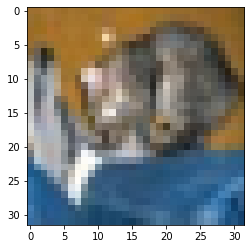

In [25]:
# plt.imshow(X_test[0])
# plt.show()

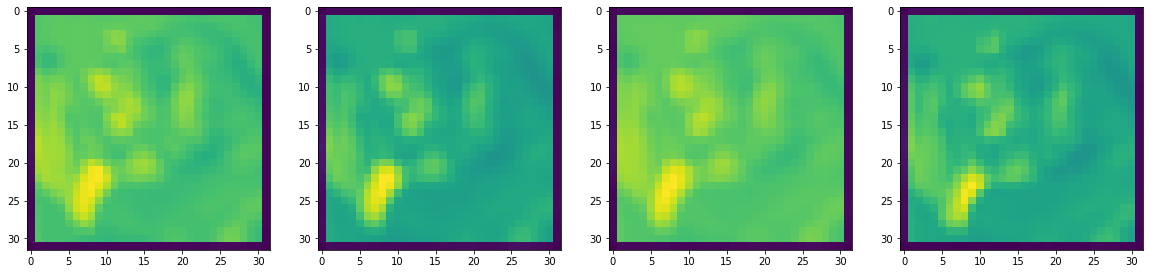

In [46]:
# plt.figure(figsize=(20,20))
# for i in range(1,5):
#     plt.subplot(1,4,i)
#     plt.imshow(trust1[0,:,:,i-1])
# plt.show()

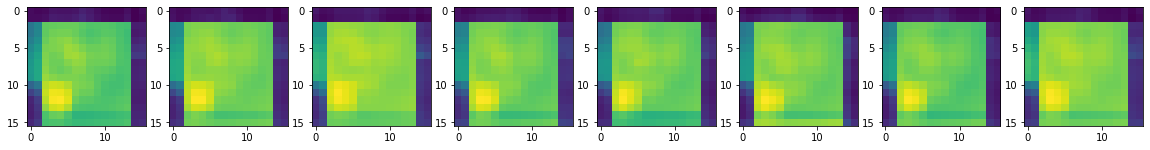

In [47]:
# plt.figure(figsize=(20,20))
# for i in range(1,9):
#     plt.subplot(1,8,i)
#     plt.imshow(trust2[0,:,:,i-1])
# plt.show()

In [450]:
# opinion1 = np.moveaxis(opinion1, -1, 0)
# opinion2 = np.moveaxis(opinion2, -1, 0)

In [452]:
# max_trust1 = opinion1[0]+opinion1[2]*opinion1[3]
# max_trust2 = opinion2[0]+opinion2[2]*opinion2[3]

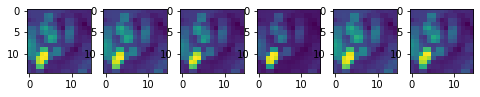

In [455]:
# plt.figure()
# for i in range(1,7):
#     plt.subplot(1,6,i)
#     plt.imshow(max_trust1[0,:,:,i-1])
# plt.show()

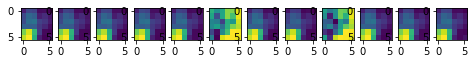

In [456]:
# plt.figure()
# for i in range(1,13):
#     plt.subplot(1,12,i)
#     plt.imshow(max_trust2[0,:,:,i-1])
# plt.show()

In [137]:
# X_test_noise, y_test_noise, noise_opinion = data_loader.get_batch_noise(800,10000)
# y_pred_test_noise,_,_,opinionlast= model([X_test_noise, noise_opinion, W_w1, W_b1, W_w2, W_b2])
# sparse_categorical_accuracy.reset_states()
# sparse_categorical_accuracy.update_state(y_true=y_test_noise, y_pred=y_pred_test_noise)
# print("test accuracy:",sparse_categorical_accuracy.result().numpy())

First 2 layers end: 168828.08871221542
underflow or not: False
Second 2 layers end: 169062.17975068092
test accuracy: 0.4875
